In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import anndata as ad

base = Path("data_orig")

# File paths
marker_fp = base / "Adult_meta_DGE_markers.csv"
genes_fp = base / "genes.npy"
samples_fp = base / "samples.npy"
h5ad_filenames = [
    "Adult_metencephalon_rep1_2_DP8400015234BL_B1-2_region_ann.h5ad",
    "Adult_metencephalon_rep3_DP8400015234BL_A3-1_region_ann.h5ad",
    "Adult_olfactory_bulb_rep1_DP8400015234BL_A1-1_region_ann.h5ad",
    "Adult_olfactory_bulb_rep2_DP8400015234BL_A2-2_region_ann.h5ad",
    "Adult_pituitary_rep1_2_DP8400015234BL_B1-2_region_ann.h5ad",
    "Adult_telencephalon_rep1_DP8400015234BL_A2-1_region_ann.h5ad",
    "Adult_telencephalon_rep3_DP8400015234BL_A4-1_region_ann.h5ad",
    "Adult_thalamencephalon_rep1_DP8400015234BL_A5-1_region_ann.h5ad",
    "Adult_thalamencephalon_rep2_DP8400015234BL_A5-2_region_ann.h5ad",
    "Adult_thalamencephalon_rep3_DP8400015234BL_A6-1_region_ann.h5ad",
]
h5ad_fps = [base / fn for fn in h5ad_filenames]

# Load files
df_markers = pd.read_csv(marker_fp)
genes = np.load(genes_fp, allow_pickle=True)
samples = np.load(samples_fp, allow_pickle=True)

# ensure string dtype for gene names if stored as bytes
if getattr(genes, "dtype", None) is not None and genes.dtype.kind == "S":
    genes = genes.astype(str)

# Load AnnData objects into a dict keyed by file stem
h5ads = {p.stem: ad.read_h5ad(p) for p in h5ad_fps}

# Quick summary
print("Markers:", df_markers.shape)
print("Genes:", getattr(genes, "shape", None))
print("Samples:", getattr(samples, "shape", None))
print("Loaded AnnData objects:", list(h5ads.keys()))

/var/folders/62/0nz2_4cx7m5fddwztmh0lflc0000gp/T/ipykernel_4224/4229873322.py:27: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  df_markers = pd.read_csv(marker_fp)


Markers: (88424, 16)
Genes: (20406,)
Samples: (10,)
Loaded AnnData objects: ['Adult_metencephalon_rep1_2_DP8400015234BL_B1-2_region_ann', 'Adult_metencephalon_rep3_DP8400015234BL_A3-1_region_ann', 'Adult_olfactory_bulb_rep1_DP8400015234BL_A1-1_region_ann', 'Adult_olfactory_bulb_rep2_DP8400015234BL_A2-2_region_ann', 'Adult_pituitary_rep1_2_DP8400015234BL_B1-2_region_ann', 'Adult_telencephalon_rep1_DP8400015234BL_A2-1_region_ann', 'Adult_telencephalon_rep3_DP8400015234BL_A4-1_region_ann', 'Adult_thalamencephalon_rep1_DP8400015234BL_A5-1_region_ann', 'Adult_thalamencephalon_rep2_DP8400015234BL_A5-2_region_ann', 'Adult_thalamencephalon_rep3_DP8400015234BL_A6-1_region_ann']


In [2]:
sample_name = list(h5ads.keys())[0]
adata = h5ads[sample_name]
print(f"Sample: {sample_name}")
print(f"Shape: {adata.shape}")
print(f"\nobs columns:\n{adata.obs.columns.tolist()}")
print(f"\nvar columns:\n{adata.var.columns.tolist()}")
print(f"\nFirst few rows of obs:\n{adata.obs.head()}")

Sample: Adult_metencephalon_rep1_2_DP8400015234BL_B1-2_region_ann
Shape: (3188, 20406)

obs columns:
['CellID', 'spatial_leiden_e30_s8', 'Batch', 'cell_id', 'seurat_clusters', 'structure']

var columns:
['Gene']

First few rows of obs:
          CellID spatial_leiden_e30_s8  \
CELL.25  CELL.25                     6   
CELL.26  CELL.26                     5   
CELL.27  CELL.27                     6   
CELL.29  CELL.29                     6   
CELL.32  CELL.32                     6   

                                                  Batch cell_id  \
CELL.25  Adult_metencephalon_rep1_2_DP8400015234BL_B1-2      25   
CELL.26  Adult_metencephalon_rep1_2_DP8400015234BL_B1-2      26   
CELL.27  Adult_metencephalon_rep1_2_DP8400015234BL_B1-2      27   
CELL.29  Adult_metencephalon_rep1_2_DP8400015234BL_B1-2      29   
CELL.32  Adult_metencephalon_rep1_2_DP8400015234BL_B1-2      32   

        seurat_clusters             structure  
CELL.25               7                  VLMC  
CELL.26     

In [3]:
def extract_metadata(name, adata):
    """Extract metadata from an AnnData object."""
    meta = adata.obs.copy()
    meta['sample'] = name
    
    # Extract brain region from sample name
    # Format: Meta_<region>_rep<n>_...
    parts = name.split('_')
    meta['stage'] = parts[0]  # 'Meta'
    meta['brain_region'] = parts[1].replace('_', ' ')  # e.g., 'metencephalon', 'olfactory'
    if 'olfactory' in name:
        meta['brain_region'] = 'olfactory_bulb'
    meta['replicate'] = parts[2] if len(parts) > 2 else 'rep1'
    
    # Calculate QC metrics if not present
    if 'n_genes' not in meta.columns and 'nFeature_RNA' not in meta.columns:
        meta['n_genes'] = (adata.X > 0).sum(axis=1).A1 if hasattr(adata.X, 'A1') else (adata.X > 0).sum(axis=1)
    if 'total_counts' not in meta.columns and 'nCount_RNA' not in meta.columns:
        meta['total_counts'] = adata.X.sum(axis=1).A1 if hasattr(adata.X, 'A1') else adata.X.sum(axis=1)
    
    return meta

# Combine all metadata
all_meta = pd.concat([extract_metadata(name, adata) for name, adata in h5ads.items()], ignore_index=True)

# Standardize column names (check what's available)
print("Available columns:", all_meta.columns.tolist())
print(f"\nTotal cells: {len(all_meta)}")
print(f"\nCells per sample:\n{all_meta['sample'].value_counts()}")

Available columns: ['CellID', 'spatial_leiden_e30_s8', 'Batch', 'cell_id', 'seurat_clusters', 'structure', 'sample', 'stage', 'brain_region', 'replicate', 'n_genes', 'total_counts']

Total cells: 49925

Cells per sample:
sample
Adult_telencephalon_rep1_DP8400015234BL_A2-1_region_ann       7987
Adult_telencephalon_rep3_DP8400015234BL_A4-1_region_ann       7566
Adult_olfactory_bulb_rep1_DP8400015234BL_A1-1_region_ann      6659
Adult_olfactory_bulb_rep2_DP8400015234BL_A2-2_region_ann      6261
Adult_thalamencephalon_rep2_DP8400015234BL_A5-2_region_ann    5837
Adult_thalamencephalon_rep3_DP8400015234BL_A6-1_region_ann    5237
Adult_thalamencephalon_rep1_DP8400015234BL_A5-1_region_ann    4530
Adult_metencephalon_rep1_2_DP8400015234BL_B1-2_region_ann     3188
Adult_pituitary_rep1_2_DP8400015234BL_B1-2_region_ann         1364
Adult_metencephalon_rep3_DP8400015234BL_A3-1_region_ann       1296
Name: count, dtype: int64


In [4]:
# Map column names based on what's available
qc_cols = {}

# Check for gene count columns
for col in ['nFeature_RNA', 'n_genes', 'n_genes_by_counts']:
    if col in all_meta.columns:
        qc_cols['n_genes'] = col
        break

# Check for UMI count columns  
for col in ['nCount_RNA', 'total_counts', 'n_counts']:
    if col in all_meta.columns:
        qc_cols['n_counts'] = col
        break

# Check for spot number
for col in ['Spot.Number', 'spot_number', 'n_spots']:
    if col in all_meta.columns:
        qc_cols['n_spots'] = col
        break

print("QC columns found:", qc_cols)

# Create standardized QC dataframe
qc_data = all_meta[['sample', 'stage', 'brain_region', 'replicate']].copy()
if 'n_genes' in qc_cols:
    qc_data['n_genes'] = all_meta[qc_cols['n_genes']].values
if 'n_counts' in qc_cols:
    qc_data['n_counts'] = all_meta[qc_cols['n_counts']].values
if 'n_spots' in qc_cols:
    qc_data['n_spots'] = all_meta[qc_cols['n_spots']].values

print(qc_data.head())

QC columns found: {'n_genes': 'n_genes', 'n_counts': 'total_counts'}
                                              sample  stage   brain_region  \
0  Adult_metencephalon_rep1_2_DP8400015234BL_B1-2...  Adult  metencephalon   
1  Adult_metencephalon_rep1_2_DP8400015234BL_B1-2...  Adult  metencephalon   
2  Adult_metencephalon_rep1_2_DP8400015234BL_B1-2...  Adult  metencephalon   
3  Adult_metencephalon_rep1_2_DP8400015234BL_B1-2...  Adult  metencephalon   
4  Adult_metencephalon_rep1_2_DP8400015234BL_B1-2...  Adult  metencephalon   

  replicate  n_genes     n_counts  
0      rep1      679  1051.276123  
1      rep1      715  1109.704346  
2      rep1     1886  1879.077393  
3      rep1     1147  1321.344238  
4      rep1      930  1215.941162  


In [5]:
brain_levels = ['olfactory_bulb', 'telencephalon', 'thalamencephalon', 'metencephalon', 'pituitary']

qc_stats = qc_data.groupby('sample').agg(
    median_genes=('n_genes', 'median'),
    mean_genes=('n_genes', 'mean'),
    median_umis=('n_counts', 'median'),
    mean_umis=('n_counts', 'mean'),
    cell_count=('sample', 'count'),
    brain_region=('brain_region', 'first'),
    stage=('stage', 'first'),
    replicate=('replicate', 'first')
).reset_index()

# Add spot statistics if available
if 'n_spots' in qc_data.columns:
    spot_stats = qc_data.groupby('sample').agg(
        median_spots=('n_spots', 'median'),
        mean_spots=('n_spots', 'mean')
    ).reset_index()
    qc_stats = qc_stats.merge(spot_stats, on='sample')

# Sort by brain region anatomical order
qc_stats['brain_region'] = pd.Categorical(qc_stats['brain_region'], categories=brain_levels, ordered=True)
qc_stats = qc_stats.sort_values('brain_region')

print("QC Summary Statistics:")
print(qc_stats.to_string(index=False))

# Save to CSV
qc_stats.to_csv("result/qc_meta_summary.csv", index=False)
print("\nSaved to result/qc_meta_summary.csv")

QC Summary Statistics:
                                                    sample  median_genes  mean_genes  median_umis   mean_umis  cell_count     brain_region stage replicate
  Adult_olfactory_bulb_rep1_DP8400015234BL_A1-1_region_ann         912.0  936.029134  1049.999023 1034.749268        6659   olfactory_bulb Adult      bulb
  Adult_olfactory_bulb_rep2_DP8400015234BL_A2-2_region_ann        1189.0 1204.131449  1349.174316 1315.519531        6261   olfactory_bulb Adult      bulb
   Adult_telencephalon_rep1_DP8400015234BL_A2-1_region_ann        1330.0 1333.291974  1499.347656 1453.484741        7987    telencephalon Adult      rep1
   Adult_telencephalon_rep3_DP8400015234BL_A4-1_region_ann         796.0  814.872984   880.611755  842.008789        7566    telencephalon Adult      rep3
Adult_thalamencephalon_rep1_DP8400015234BL_A5-1_region_ann        1642.0 1681.856733  1970.434082 1897.572632        4530 thalamencephalon Adult      rep1
Adult_thalamencephalon_rep2_DP8400015234BL_A5-2

In [6]:
print("\nSamples per brain region:")
print(qc_stats.groupby('brain_region').size())


Samples per brain region:
brain_region
olfactory_bulb      2
telencephalon       2
thalamencephalon    3
metencephalon       2
pituitary           1
dtype: int64


/var/folders/62/0nz2_4cx7m5fddwztmh0lflc0000gp/T/ipykernel_4224/2709883135.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(qc_stats.groupby('brain_region').size())


/var/folders/62/0nz2_4cx7m5fddwztmh0lflc0000gp/T/ipykernel_4224/3477117562.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')
/var/folders/62/0nz2_4cx7m5fddwztmh0lflc0000gp/T/ipykernel_4224/3477117562.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right')


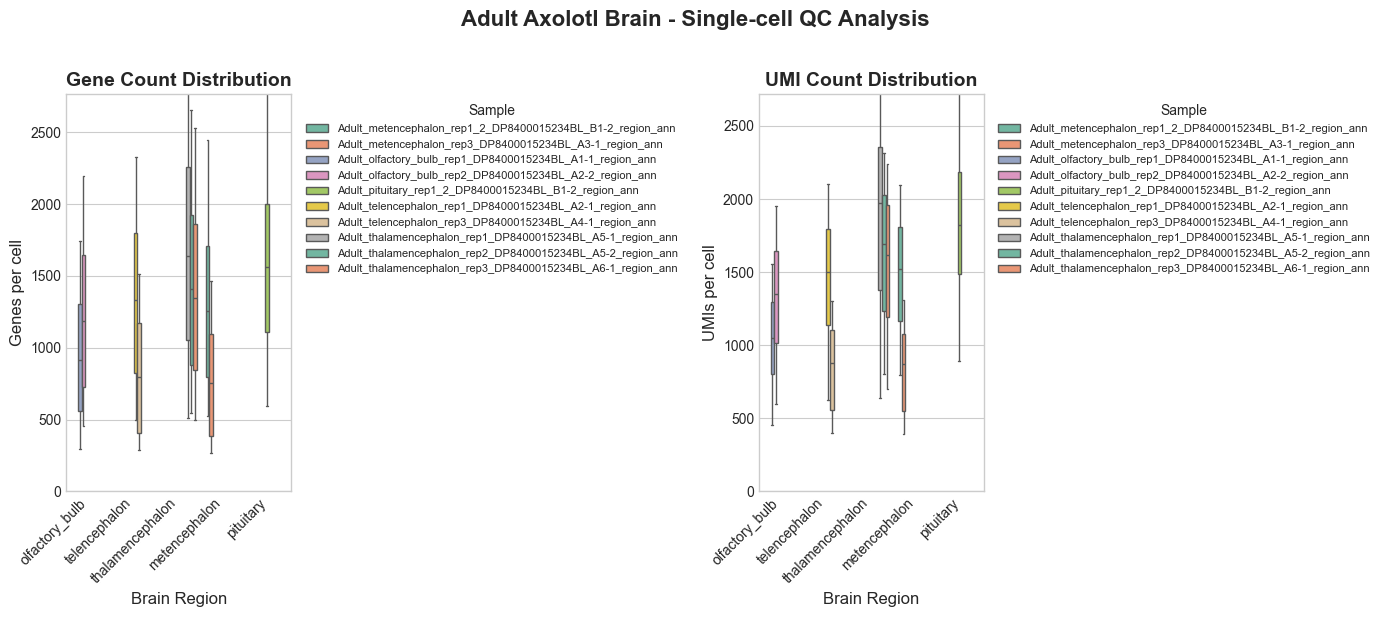


Plots saved to result/qc_meta_plots.pdf and result/qc_meta_plots.png


In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Create result directory if it doesn't exist
Path("result").mkdir(exist_ok=True)

# Set style
plt.style.use('seaborn-v0_8-whitegrid')
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Define brain region order and colors
brain_levels = ['olfactory_bulb', 'telencephalon', 'thalamencephalon', 'metencephalon', 'pituitary']

# Ensure categorical ordering
qc_data['brain_region'] = pd.Categorical(qc_data['brain_region'], categories=brain_levels, ordered=True)

# A: Gene count distribution (boxplot)
ax1 = axes[0]
sns.boxplot(data=qc_data, x='brain_region', y='n_genes', hue='sample', 
            palette='Set2', ax=ax1, showfliers=False)
ax1.set_title('Gene Count Distribution', fontsize=14, fontweight='bold')
ax1.set_xlabel('Brain Region', fontsize=12)
ax1.set_ylabel('Genes per cell', fontsize=12)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')
ax1.set_ylim(0, qc_data['n_genes'].quantile(0.99) * 1.1)
ax1.legend(title='Sample', bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=8)

# B: UMI count distribution (boxplot)
ax2 = axes[1]
sns.boxplot(data=qc_data, x='brain_region', y='n_counts', hue='sample',
            palette='Set2', ax=ax2, showfliers=False)
ax2.set_title('UMI Count Distribution', fontsize=14, fontweight='bold')
ax2.set_xlabel('Brain Region', fontsize=12)
ax2.set_ylabel('UMIs per cell', fontsize=12)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right')
ax2.set_ylim(0, qc_data['n_counts'].quantile(0.99) * 1.1)
ax2.legend(title='Sample', bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=8)

plt.suptitle('Adult Axolotl Brain - Single-cell QC Analysis', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('result/qc_meta_plots.pdf', dpi=300, bbox_inches='tight')
plt.savefig('result/qc_meta_plots.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nPlots saved to result/qc_meta_plots.pdf and result/qc_meta_plots.png")

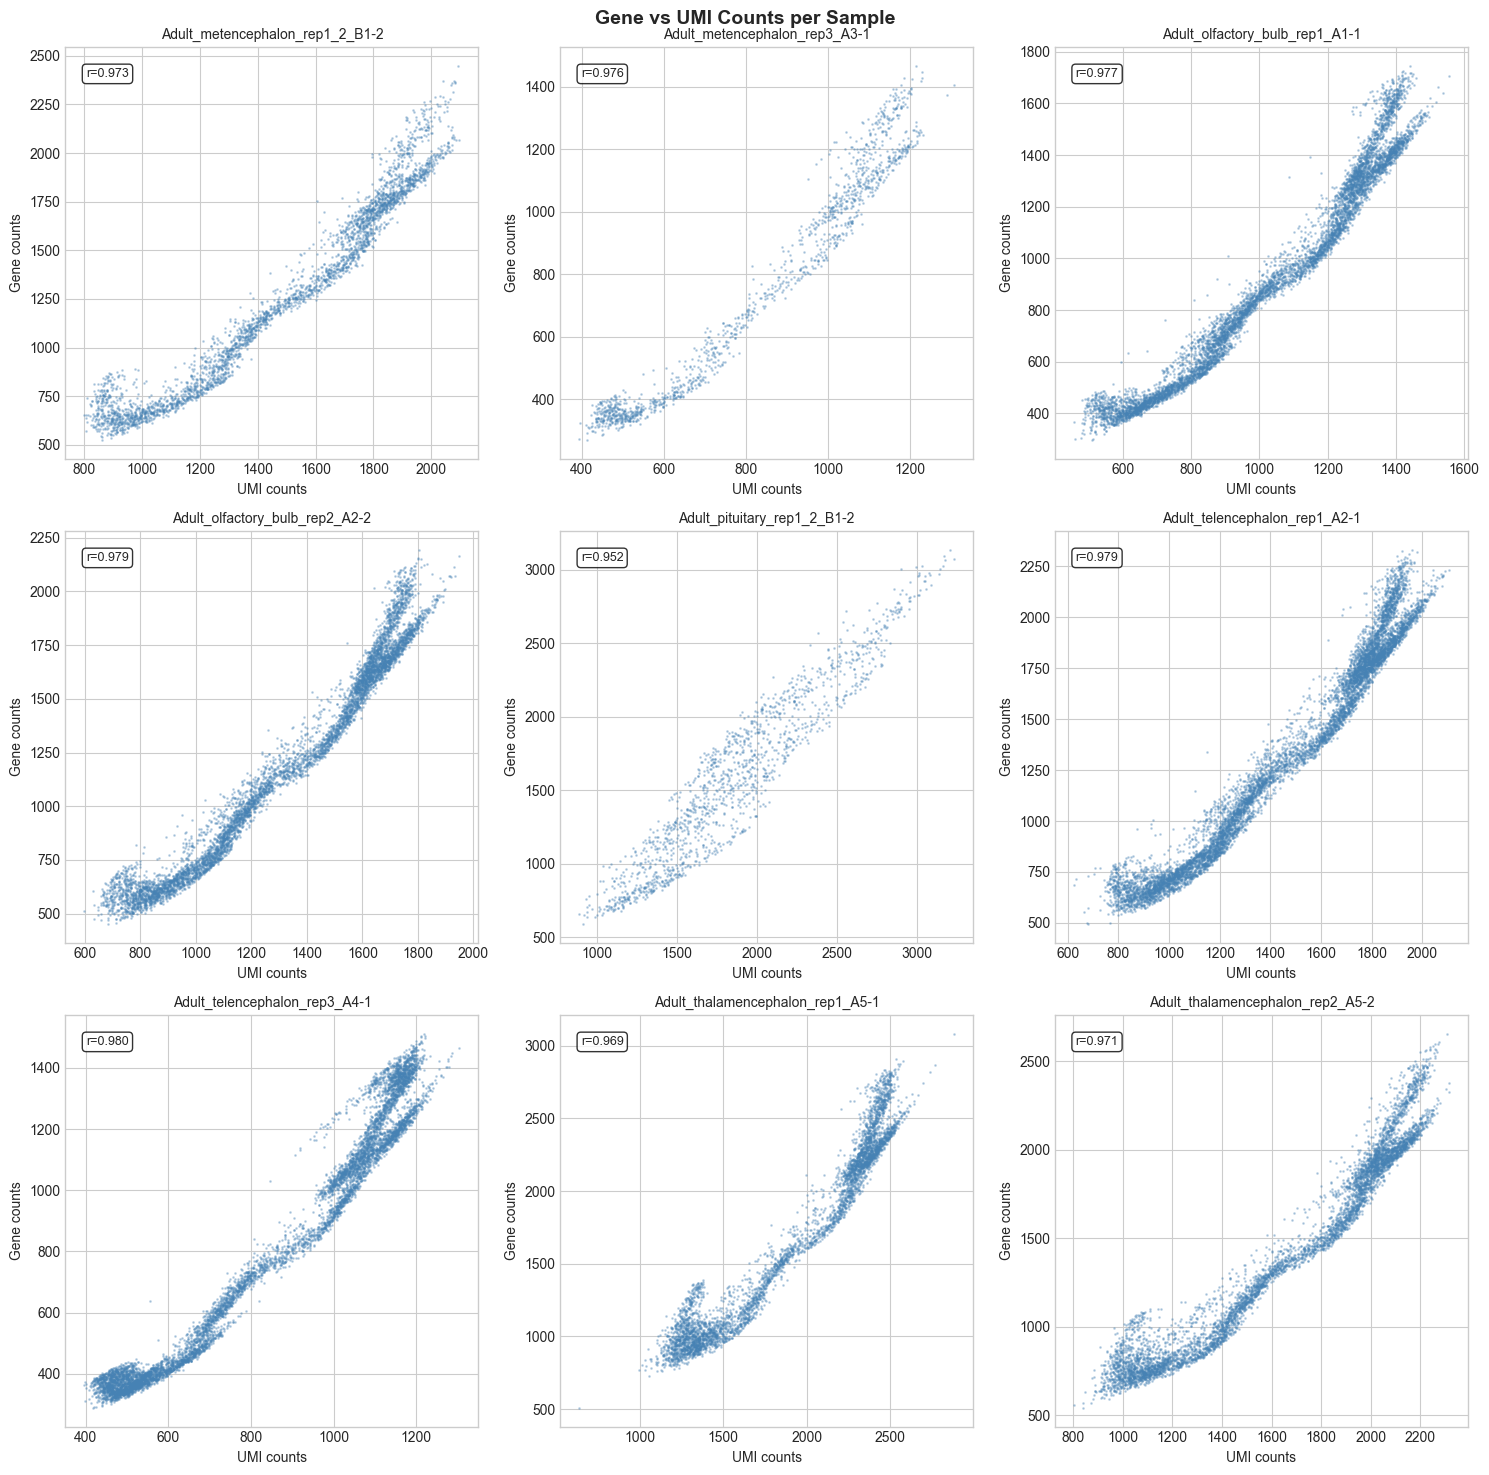


Scatter plots saved to result/qc_scatter_plots.pdf


In [8]:
# Cell 8: Additional QC - Gene vs UMI scatter plot per sample
fig, axes = plt.subplots(3, 3, figsize=(15, 15))
axes = axes.flatten()

for idx, (name, adata) in enumerate(h5ads.items()):
    if idx >= 9:
        break
    ax = axes[idx]
    
    # Get QC data for this sample
    sample_data = qc_data[qc_data['sample'] == name]
    
    ax.scatter(sample_data['n_counts'], sample_data['n_genes'], 
               alpha=0.3, s=1, c='steelblue')
    ax.set_xlabel('UMI counts')
    ax.set_ylabel('Gene counts')
    
    # Shorten title
    short_name = name.replace('_region_ann', '').replace('DP8400015649BR_', '').replace('DP8400015234BL_', '')
    ax.set_title(short_name, fontsize=10)
    
    # Add correlation
    corr = sample_data['n_counts'].corr(sample_data['n_genes'])
    ax.text(0.05, 0.95, f'r={corr:.3f}', transform=ax.transAxes, fontsize=9,
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.suptitle('Gene vs UMI Counts per Sample', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('result/qc_scatter_plots.pdf', dpi=300, bbox_inches='tight')
plt.savefig('result/qc_scatter_plots.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nScatter plots saved to result/qc_scatter_plots.pdf")

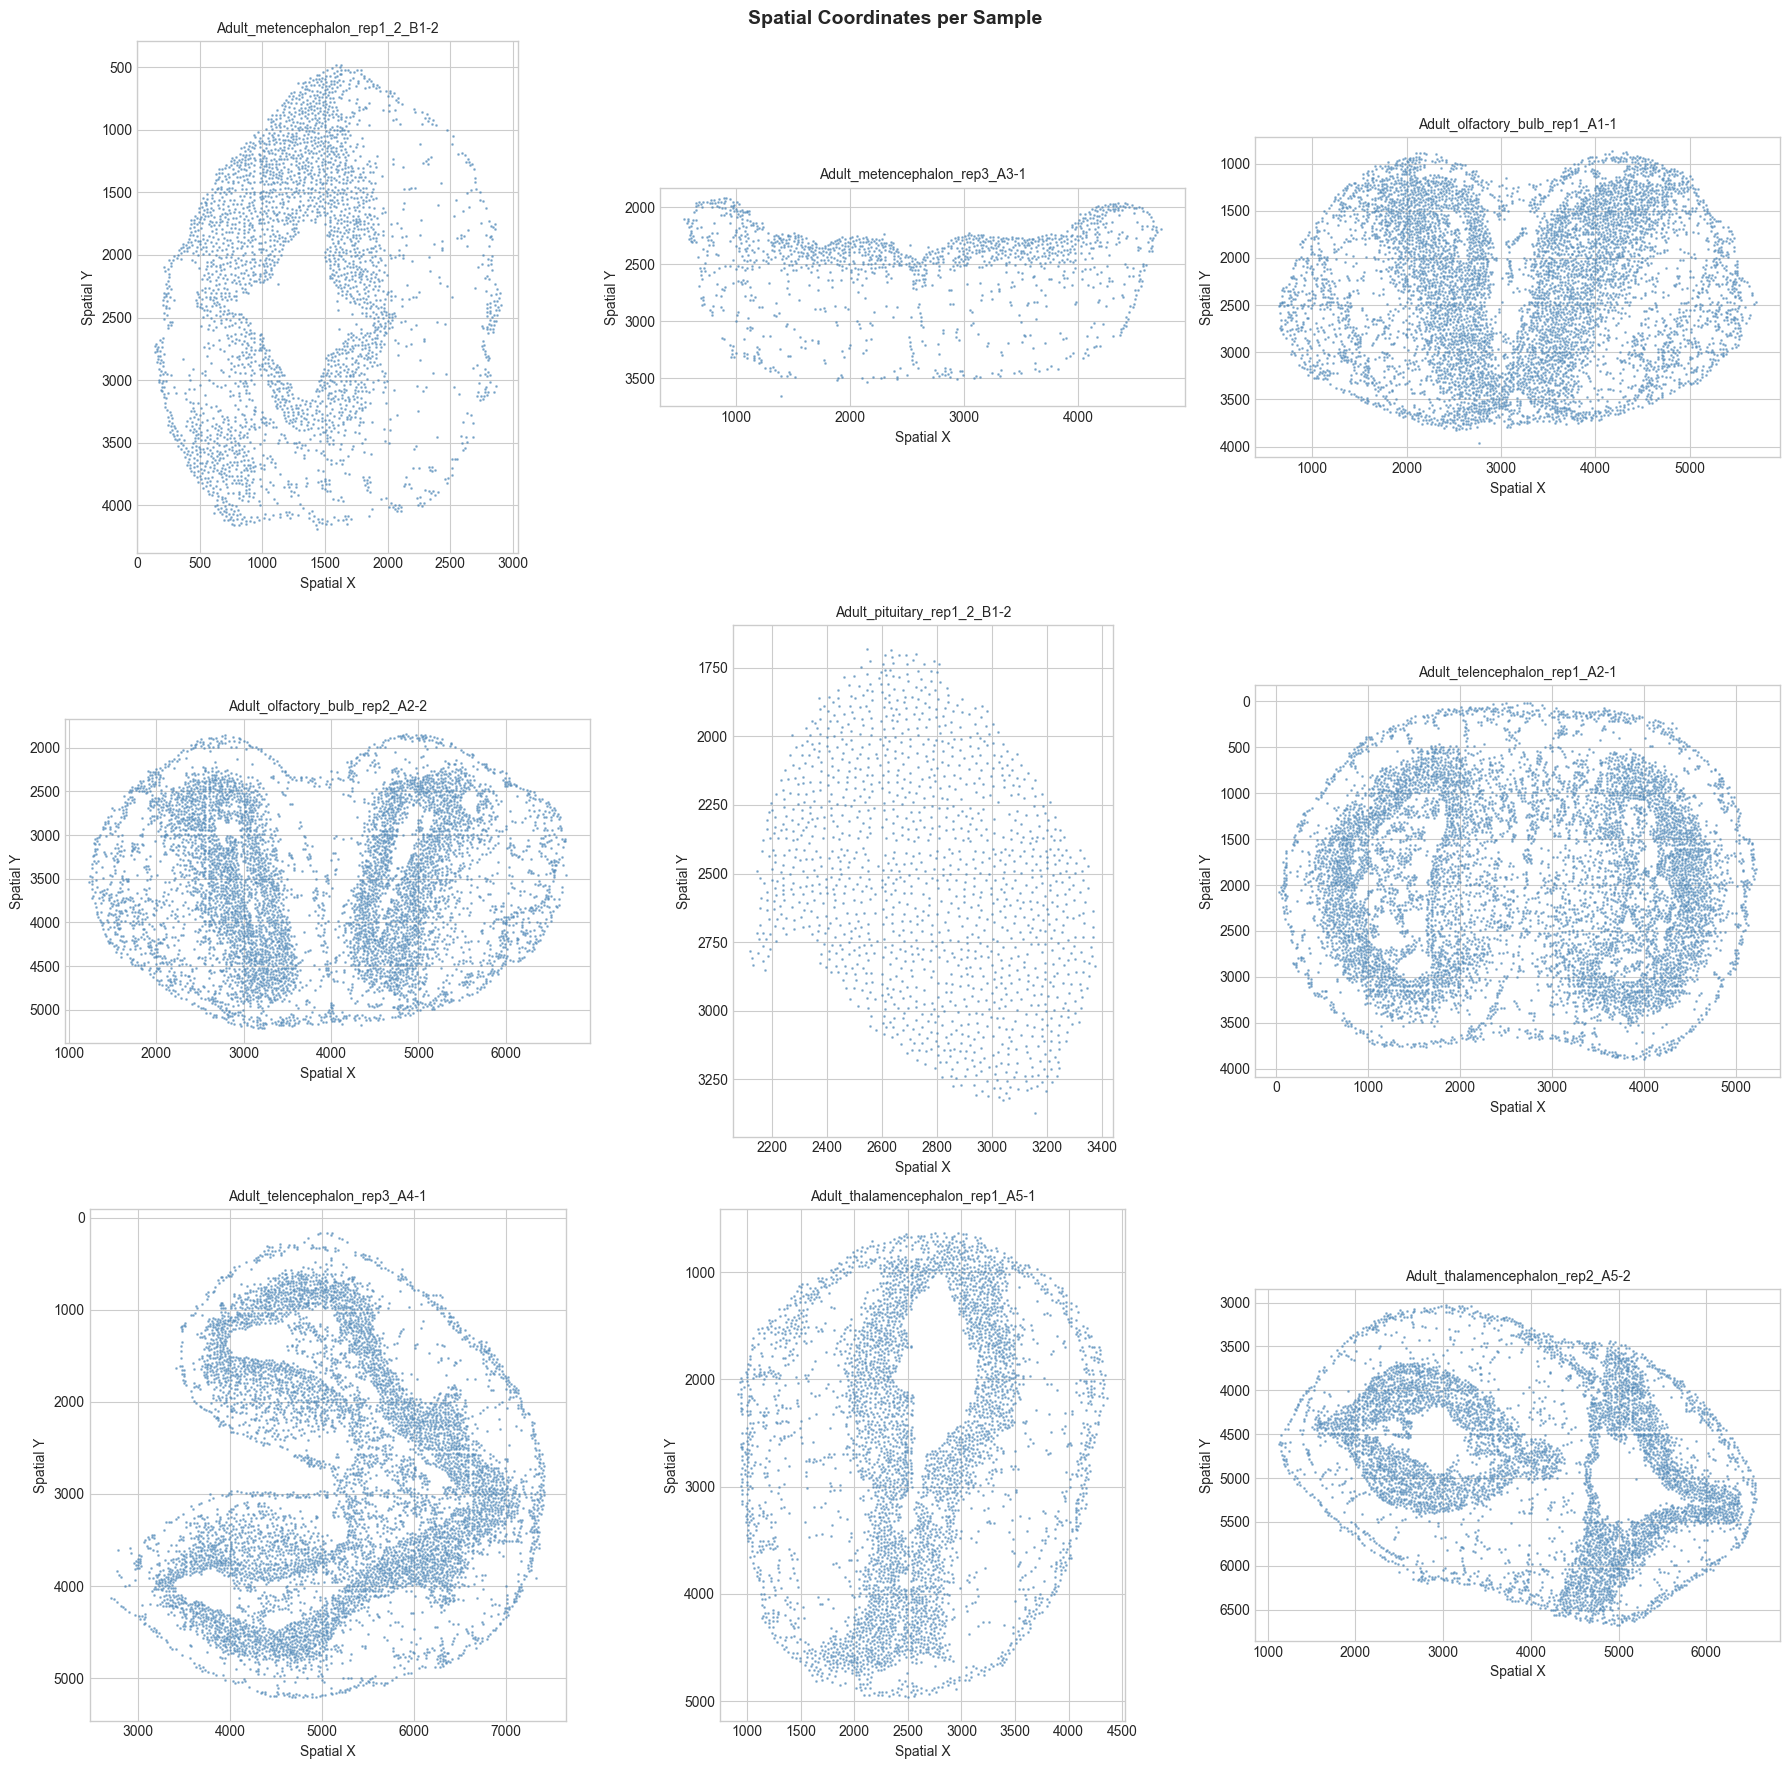


Spatial overview saved to result/spatial_overview.pdf


In [9]:
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(3, 3, figsize=(18, 18))
axes = axes.flatten()

for idx, (name, adata) in enumerate(h5ads.items()):
    if idx >= 9:
        break
    ax = axes[idx]
    
    # Get spatial coordinates
    if 'spatial' in adata.obsm:
        coords = adata.obsm['spatial']
    elif 'X_spatial' in adata.obsm:
        coords = adata.obsm['X_spatial']
    else:
        # Try to find x, y in obs
        x_col = [c for c in adata.obs.columns if 'x' in c.lower() and 'umap' not in c.lower()]
        y_col = [c for c in adata.obs.columns if 'y' in c.lower() and 'umap' not in c.lower()]
        if x_col and y_col:
            coords = np.column_stack([adata.obs[x_col[0]].values, adata.obs[y_col[0]].values])
        else:
            ax.text(0.5, 0.5, 'No spatial coords found', ha='center', va='center', transform=ax.transAxes)
            ax.set_title(name.split('_')[1], fontsize=10)
            continue
    
    # Plot spatial coordinates
    scatter = ax.scatter(coords[:, 0], coords[:, 1], s=1, alpha=0.5, c='steelblue')
    
    # Shorten title
    short_name = name.replace('_region_ann', '').replace('DP8400015649BR_', '').replace('DP8400015234BL_', '')
    ax.set_title(short_name, fontsize=10)
    ax.set_xlabel('Spatial X')
    ax.set_ylabel('Spatial Y')
    ax.set_aspect('equal')
    ax.invert_yaxis()  # Often spatial data has inverted y-axis

plt.suptitle('Spatial Coordinates per Sample', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('result/spatial_overview.pdf', dpi=300, bbox_inches='tight')
plt.savefig('result/spatial_overview.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nSpatial overview saved to result/spatial_overview.pdf")

In [10]:
# Rotate spatial coordinates for specific samples and save as new files

def rotate_coords(coords, angle_degrees):
    """Rotate coordinates anticlockwise by given angle (in degrees) around centroid."""
    angle_rad = np.radians(angle_degrees)
    
    # Calculate centroid
    centroid = coords.mean(axis=0)
    
    # Translate to origin
    centered = coords - centroid
    
    # Rotation matrix (anticlockwise) - note: for image coordinates with inverted y-axis,
    # we need to negate the angle to get visual anticlockwise rotation
    cos_a, sin_a = np.cos(-angle_rad), np.sin(-angle_rad)
    rotation_matrix = np.array([
        [cos_a, -sin_a],
        [sin_a,  cos_a]
    ])
    
    # Apply rotation
    rotated = centered @ rotation_matrix.T
    
    # Translate back
    return rotated + centroid

# Define rotations for specific samples (sample stem -> angle in degrees)
rotations = {
    "Adult_metencephalon_rep1_2_DP8400015234BL_B1-2_region_ann": 270,
    "Adult_pituitary_rep1_2_DP8400015234BL_B1-2_region_ann": 270,
    "Adult_telencephalon_rep3_DP8400015234BL_A4-1_region_ann": 270,
    "Adult_thalamencephalon_rep2_DP8400015234BL_A5-2_region_ann": 280,
    "Adult_thalamencephalon_rep3_DP8400015234BL_A6-1_region_ann" : 100,
}

# Process all samples
for name, adata in h5ads.items():
    # Make a copy to avoid modifying the original
    adata_rot = adata.copy()
    
    # Get rotation angle (0 if not specified)
    angle = rotations.get(name, 0)
    
    # Apply rotation to spatial coordinates
    if 'spatial' in adata_rot.obsm:
        original_coords = adata_rot.obsm['spatial'].copy()
        if angle != 0:
            adata_rot.obsm['spatial'] = rotate_coords(original_coords, angle)
            print(f"Rotated {name} by {angle}° anticlockwise")
        else:
            print(f"No rotation for {name}")
    
    # Save with _rot suffix
    output_path = base / f"{name}_rot.h5ad"
    adata_rot.write_h5ad(output_path)
    print(f"  Saved to {output_path}")

print("\nAll rotated files saved!")

Rotated Adult_metencephalon_rep1_2_DP8400015234BL_B1-2_region_ann by 270° anticlockwise
  Saved to data_orig/Adult_metencephalon_rep1_2_DP8400015234BL_B1-2_region_ann_rot.h5ad
No rotation for Adult_metencephalon_rep3_DP8400015234BL_A3-1_region_ann
  Saved to data_orig/Adult_metencephalon_rep3_DP8400015234BL_A3-1_region_ann_rot.h5ad
No rotation for Adult_olfactory_bulb_rep1_DP8400015234BL_A1-1_region_ann
  Saved to data_orig/Adult_olfactory_bulb_rep1_DP8400015234BL_A1-1_region_ann_rot.h5ad
No rotation for Adult_olfactory_bulb_rep2_DP8400015234BL_A2-2_region_ann
  Saved to data_orig/Adult_olfactory_bulb_rep2_DP8400015234BL_A2-2_region_ann_rot.h5ad
Rotated Adult_pituitary_rep1_2_DP8400015234BL_B1-2_region_ann by 270° anticlockwise
  Saved to data_orig/Adult_pituitary_rep1_2_DP8400015234BL_B1-2_region_ann_rot.h5ad
No rotation for Adult_telencephalon_rep1_DP8400015234BL_A2-1_region_ann
  Saved to data_orig/Adult_telencephalon_rep1_DP8400015234BL_A2-1_region_ann_rot.h5ad
Rotated Adult_telenc

In [11]:
from pathlib import Path
import numpy as np
import pandas as pd
import anndata as ad

base = Path("data_orig")

# File paths
marker_fp = base / "Adult_meta_DGE_markers.csv"
genes_fp = base / "genes.npy"
samples_fp = base / "samples.npy"

# Load the ROTATED files instead of originals
h5ad_filenames = [
    "Adult_metencephalon_rep1_2_DP8400015234BL_B1-2_region_ann_rot.h5ad",
    "Adult_metencephalon_rep3_DP8400015234BL_A3-1_region_ann_rot.h5ad",
    "Adult_olfactory_bulb_rep1_DP8400015234BL_A1-1_region_ann_rot.h5ad",
    "Adult_olfactory_bulb_rep2_DP8400015234BL_A2-2_region_ann_rot.h5ad",
    "Adult_pituitary_rep1_2_DP8400015234BL_B1-2_region_ann_rot.h5ad",
    "Adult_telencephalon_rep1_DP8400015234BL_A2-1_region_ann_rot.h5ad",
    "Adult_telencephalon_rep3_DP8400015234BL_A4-1_region_ann_rot.h5ad",
    "Adult_thalamencephalon_rep1_DP8400015234BL_A5-1_region_ann_rot.h5ad",
    "Adult_thalamencephalon_rep2_DP8400015234BL_A5-2_region_ann_rot.h5ad",
    "Adult_thalamencephalon_rep3_DP8400015234BL_A6-1_region_ann_rot.h5ad",
]

# CREATE the file paths from the new filenames
h5ad_fps = [base / fn for fn in h5ad_filenames]

# Load files
df_markers = pd.read_csv(marker_fp)
genes = np.load(genes_fp, allow_pickle=True)
samples = np.load(samples_fp, allow_pickle=True)

# ensure string dtype for gene names if stored as bytes
if getattr(genes, "dtype", None) is not None and genes.dtype.kind == "S":
    genes = genes.astype(str)

# Load AnnData objects into a dict keyed by file stem (remove _rot suffix for consistency)
h5ads = {p.stem.replace('_rot', ''): ad.read_h5ad(p) for p in h5ad_fps}

# Quick summary
print("Markers:", df_markers.shape)
print("Genes:", getattr(genes, "shape", None))
print("Samples:", getattr(samples, "shape", None))
print("Loaded AnnData objects:", list(h5ads.keys()))

/var/folders/62/0nz2_4cx7m5fddwztmh0lflc0000gp/T/ipykernel_4224/1526963163.py:31: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  df_markers = pd.read_csv(marker_fp)


Markers: (88424, 16)
Genes: (20406,)
Samples: (10,)
Loaded AnnData objects: ['Adult_metencephalon_rep1_2_DP8400015234BL_B1-2_region_ann', 'Adult_metencephalon_rep3_DP8400015234BL_A3-1_region_ann', 'Adult_olfactory_bulb_rep1_DP8400015234BL_A1-1_region_ann', 'Adult_olfactory_bulb_rep2_DP8400015234BL_A2-2_region_ann', 'Adult_pituitary_rep1_2_DP8400015234BL_B1-2_region_ann', 'Adult_telencephalon_rep1_DP8400015234BL_A2-1_region_ann', 'Adult_telencephalon_rep3_DP8400015234BL_A4-1_region_ann', 'Adult_thalamencephalon_rep1_DP8400015234BL_A5-1_region_ann', 'Adult_thalamencephalon_rep2_DP8400015234BL_A5-2_region_ann', 'Adult_thalamencephalon_rep3_DP8400015234BL_A6-1_region_ann']


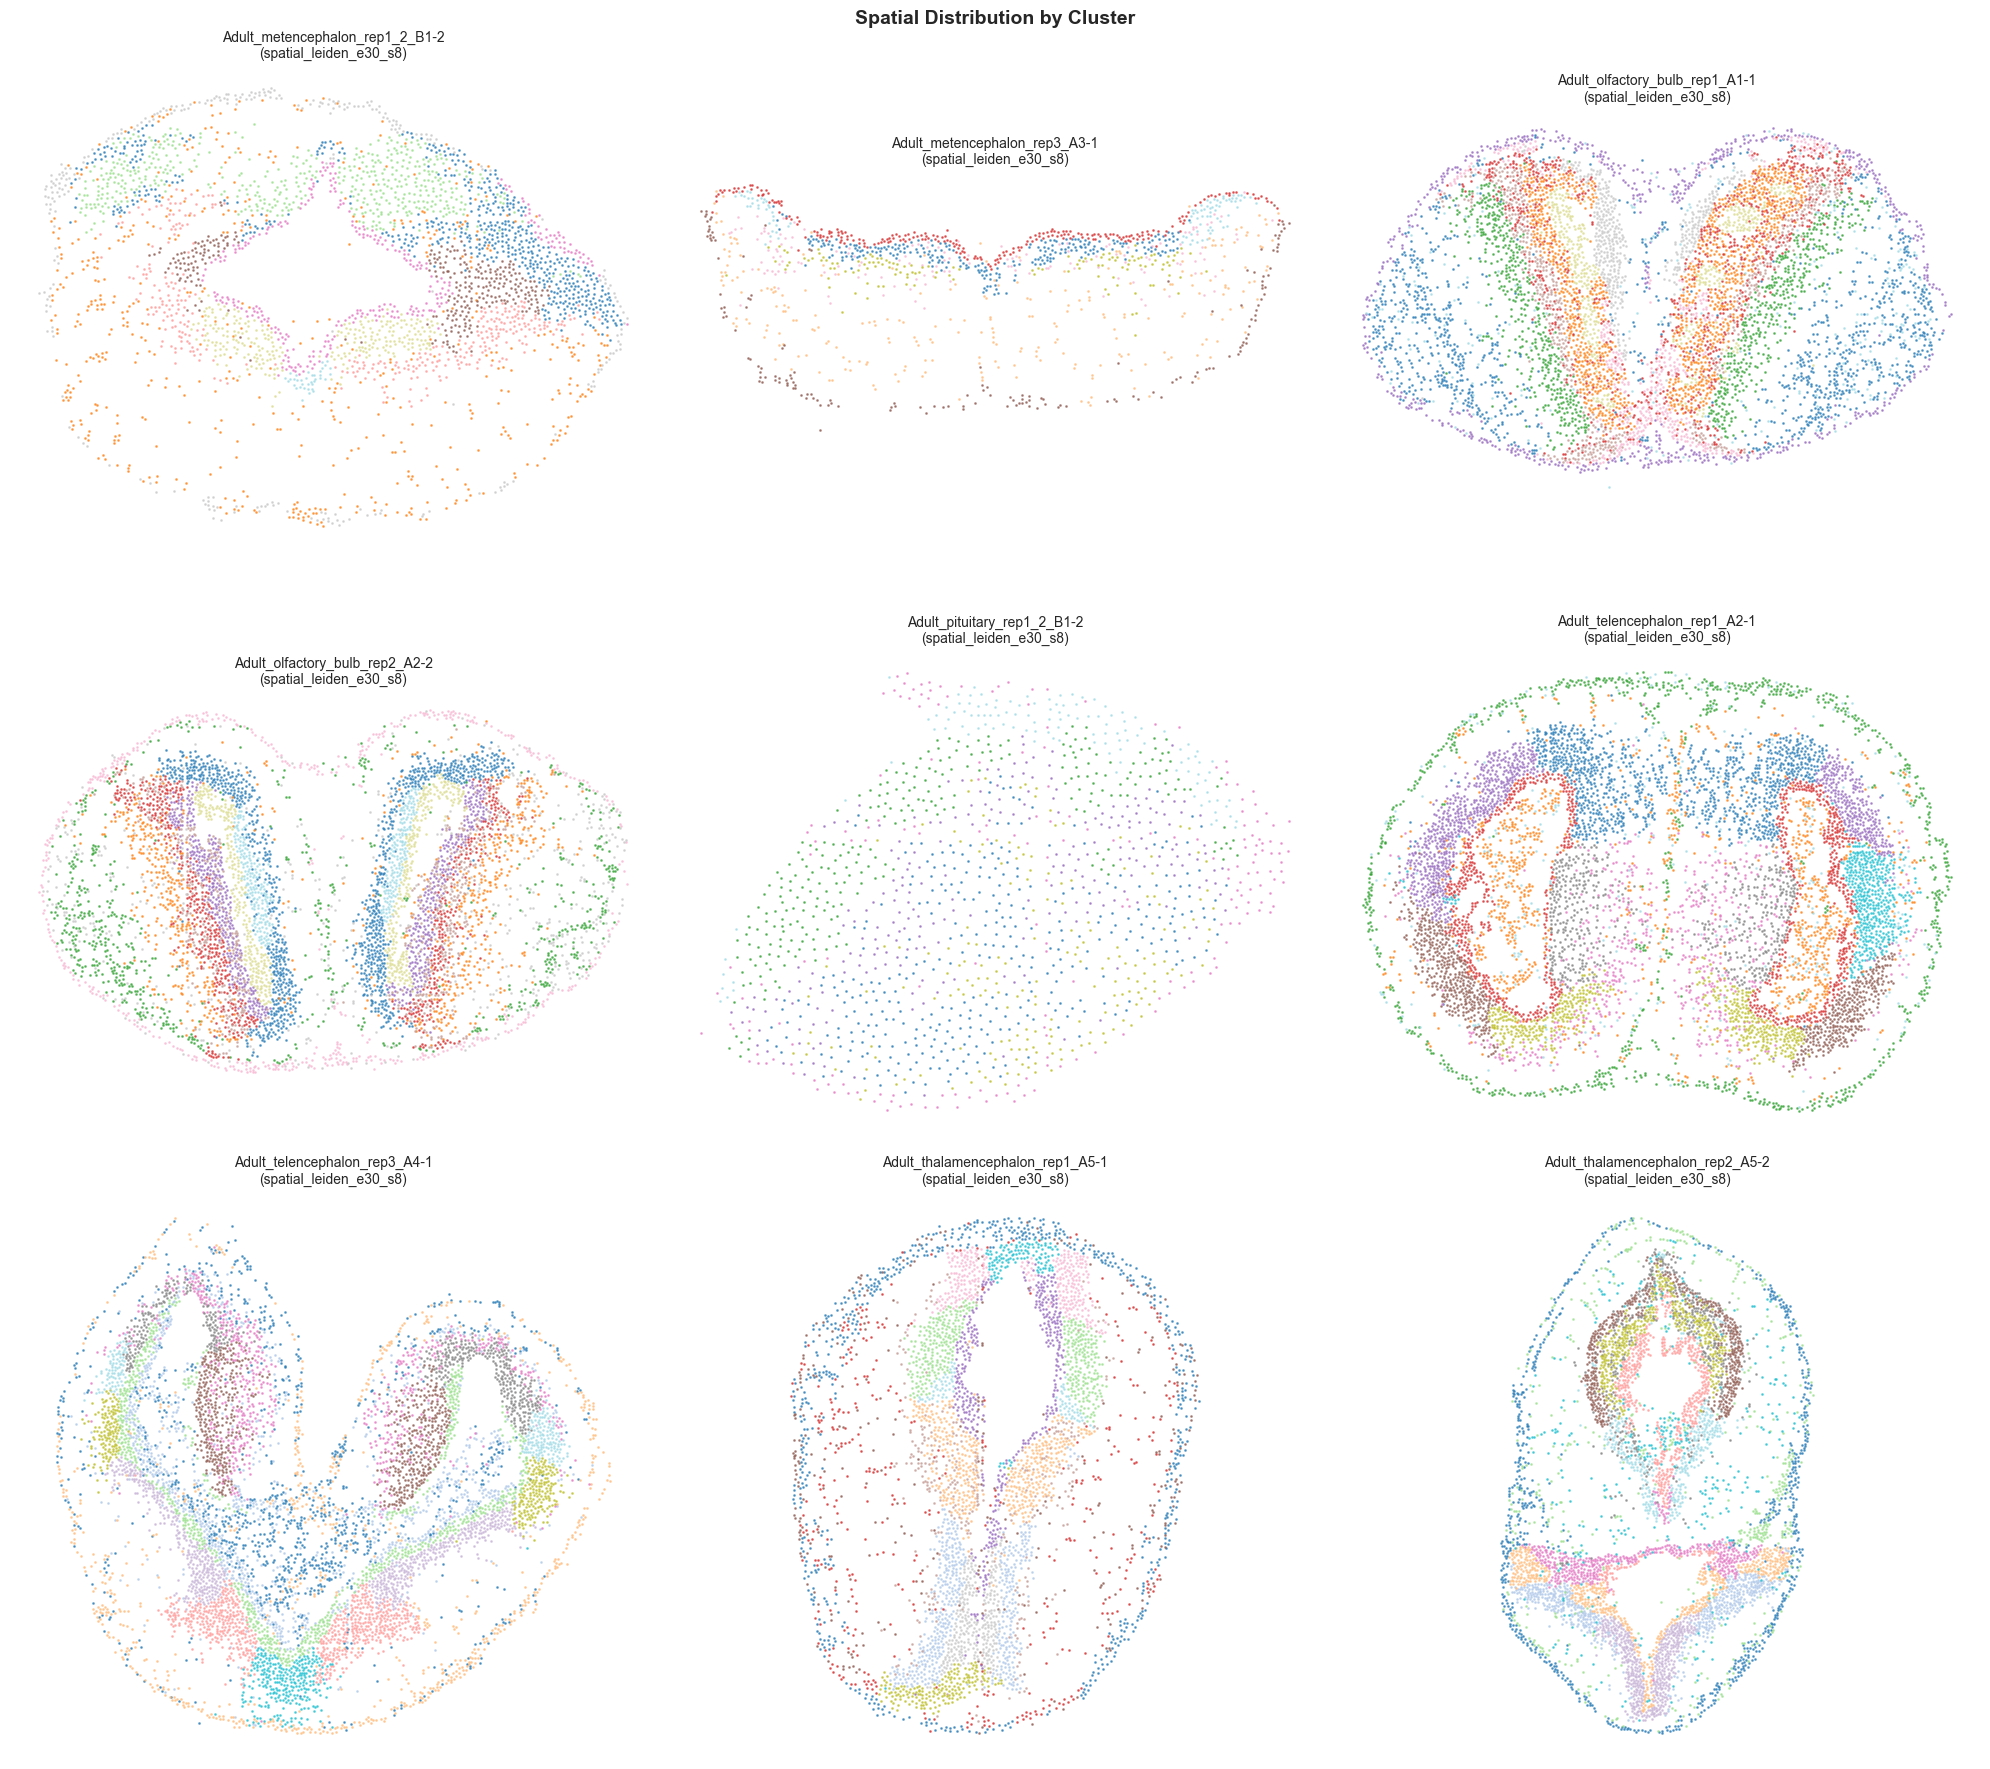


Spatial clusters saved to result/spatial_clusters.pdf


In [12]:
fig, axes = plt.subplots(3, 3, figsize=(20, 18))
axes = axes.flatten()

# Find clustering column
cluster_cols = ['spatial_leiden_e30_s8', 'seurat_clusters', 'leiden', 'louvain', 'cluster']

for idx, (name, adata) in enumerate(h5ads.items()):
    if idx >= 9:
        break
    ax = axes[idx]
    
    # Get spatial coordinates
    if 'spatial' in adata.obsm:
        coords = adata.obsm['spatial']
    elif 'X_spatial' in adata.obsm:
        coords = adata.obsm['X_spatial']
    else:
        x_col = [c for c in adata.obs.columns if 'x' in c.lower() and 'umap' not in c.lower()]
        y_col = [c for c in adata.obs.columns if 'y' in c.lower() and 'umap' not in c.lower()]
        if x_col and y_col:
            coords = np.column_stack([adata.obs[x_col[0]].values, adata.obs[y_col[0]].values])
        else:
            continue
    
    # Find available cluster column
    cluster_col = None
    for col in cluster_cols:
        if col in adata.obs.columns:
            cluster_col = col
            break
    
    if cluster_col:
        clusters = adata.obs[cluster_col].astype('category')
        n_clusters = clusters.nunique()
        colors = plt.cm.tab20(np.linspace(0, 1, min(n_clusters, 20)))
        
        for i, cluster in enumerate(clusters.cat.categories):
            mask = clusters == cluster
            ax.scatter(coords[mask, 0], coords[mask, 1], 
                      s=1, alpha=0.6, label=str(cluster),
                      c=[colors[i % 20]])
    else:
        ax.scatter(coords[:, 0], coords[:, 1], s=1, alpha=0.5, c='gray')
    
    short_name = name.replace('_region_ann', '').replace('DP8400015649BR_', '').replace('DP8400015234BL_', '')
    ax.set_title(f"{short_name}\n({cluster_col if cluster_col else 'no clusters'})", fontsize=10)
    ax.set_aspect('equal')
    ax.invert_yaxis()
    ax.axis('off')

plt.suptitle('Spatial Distribution by Cluster', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('result/spatial_clusters.pdf', dpi=300, bbox_inches='tight')
plt.savefig('result/spatial_clusters.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nSpatial clusters saved to result/spatial_clusters.pdf")

In [13]:
# Find a highly expressed gene to visualize
sample_name = list(h5ads.keys())[0]
adata = h5ads[sample_name]

# Get mean expression per gene
if hasattr(adata.X, 'toarray'):
    mean_expr = np.array(adata.X.mean(axis=0)).flatten()
else:
    mean_expr = np.array(adata.X.mean(axis=0)).flatten()

# Get top expressed genes
top_genes_idx = np.argsort(mean_expr)[-10:][::-1]
top_genes = adata.var_names[top_genes_idx].tolist()
print("Top 10 expressed genes:")
for i, gene in enumerate(top_genes):
    print(f"  {i+1}. {gene}: {mean_expr[top_genes_idx[i]]:.2f}")

# Select a gene to visualize
gene_to_plot = top_genes[0]
print(f"\nPlotting gene: {gene_to_plot}")

Top 10 expressed genes:
  1. AMEX60DD038502: 4.50
  2. AMEX60DD020311: 3.75
  3. AMEX60DD026859: 3.07
  4. AMEX60DD001331: 2.83
  5. AMEX60DD016343: 2.74
  6. AMEX60DD035913: 2.72
  7. AMEX60DD029926: 2.69
  8. AMEX60DD032108: 2.62
  9. AMEX60DD038454: 2.61
  10. AMEX60DD013527: 2.38

Plotting gene: AMEX60DD038502


In [14]:
# Create gene name mapping from markers file
# Use Human_Annotation, but if it's 'NA' or NaN, use Axolotl_tanaka_annotated_gene

# Read markers file
df_markers = pd.read_csv(marker_fp, index_col=0)

# Create mapping dictionary: AMEX ID -> Human gene name (or Axolotl if Human is NA)
gene_mapping = {}
for amex_id, row in df_markers.iterrows():
    human_annot = row['Human_Annotation']
    axolotl_annot = row['Axolotl_tanaka_annotated_gene']
    
    # Use Human_Annotation if available and not 'NA'
    if pd.notna(human_annot) and str(human_annot) != 'NA':
        gene_mapping[amex_id] = str(human_annot)
    # Otherwise use Axolotl annotation if available and not 'N/A'
    elif pd.notna(axolotl_annot) and str(axolotl_annot) != 'N/A':
        gene_mapping[amex_id] = str(axolotl_annot)
    # If both are NA, keep the original AMEX ID
    else:
        gene_mapping[amex_id] = str(amex_id)

print(f"Created mapping for {len(gene_mapping)} genes")
print("\nExample mappings:")
for i, (k, v) in enumerate(list(gene_mapping.items())[:10]):
    print(f"  {k} -> {v}")

# Rename genes in all AnnData objects
for name, adata in h5ads.items():
    # Create new var_names using the mapping, ensuring all are strings
    new_var_names = [str(gene_mapping.get(g, g)) for g in adata.var_names]
    adata.var_names = pd.Index(new_var_names)
    adata.var_names_make_unique()  # Handle any duplicates
    
print(f"\nRenamed genes in {len(h5ads)} AnnData objects")

# Verify the renaming worked
sample_name = list(h5ads.keys())[0]
print(f"\nFirst 10 gene names in {sample_name}:")
print(h5ads[sample_name].var_names[:10].tolist())

/var/folders/62/0nz2_4cx7m5fddwztmh0lflc0000gp/T/ipykernel_4224/2838866802.py:5: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  df_markers = pd.read_csv(marker_fp, index_col=0)


Created mapping for 88424 genes

Example mappings:
  AMEX60DD028300 -> B2M
  AMEX60DD013527 -> ZNF705D
  AMEX60DD050417 -> RPS12
  AMEX60DD016909 -> PPDPF
  AMEX60DD047583 -> UBA52
  AMEX60DD013534 -> GPATCH2L
  AMEX60DD009353 -> IGHE
  AMEX60DD000274 -> AMEX60DD000274
  AMEX60DD056214 -> RPL37A
  AMEX60DD005586 -> RING1

Renamed genes in 10 AnnData objects

First 10 gene names in Adult_metencephalon_rep1_2_DP8400015234BL_B1-2_region_ann:
['AMEX60DD000003', 'AMEX60DD000004', 'AMEX60DD000005', 'AMEX60DD000007', 'AMEX60DD000008', 'AMEX60DD000011', 'AMEX60DD000016', 'AMEX60DD000018', 'AMEX60DD000029', 'AMEX60DD000033']


In [15]:
# Find a highly expressed gene to visualize
sample_name = list(h5ads.keys())[0]
adata = h5ads[sample_name]

# Get mean expression per gene
if hasattr(adata.X, 'toarray'):
    mean_expr = np.array(adata.X.mean(axis=0)).flatten()
else:
    mean_expr = np.array(adata.X.mean(axis=0)).flatten()

# Get top expressed genes
top_genes_idx = np.argsort(mean_expr)[-10:][::-1]
top_genes = adata.var_names[top_genes_idx].tolist()
print("Top 10 expressed genes:")
for i, gene in enumerate(top_genes):
    print(f"  {i+1}. {gene}: {mean_expr[top_genes_idx[i]]:.2f}")

# Select a gene to visualize
gene_to_plot = top_genes[0]
print(f"\nPlotting gene: {gene_to_plot}")

Top 10 expressed genes:
  1. ND5: 4.50
  2. MT-ATP6: 3.75
  3. GAPDH: 3.07
  4. LOC111571239[nr]: 2.83
  5. FTH1[hs]: 2.74
  6. CALM2[nr]|CALM1[hs]: 2.72
  7. AMEX60DD029926: 2.69
  8. SMAX5B_007995[nr]|TUBB4B[hs]: 2.62
  9. PRL: 2.61
  10. ZNF705D: 2.38

Plotting gene: ND5


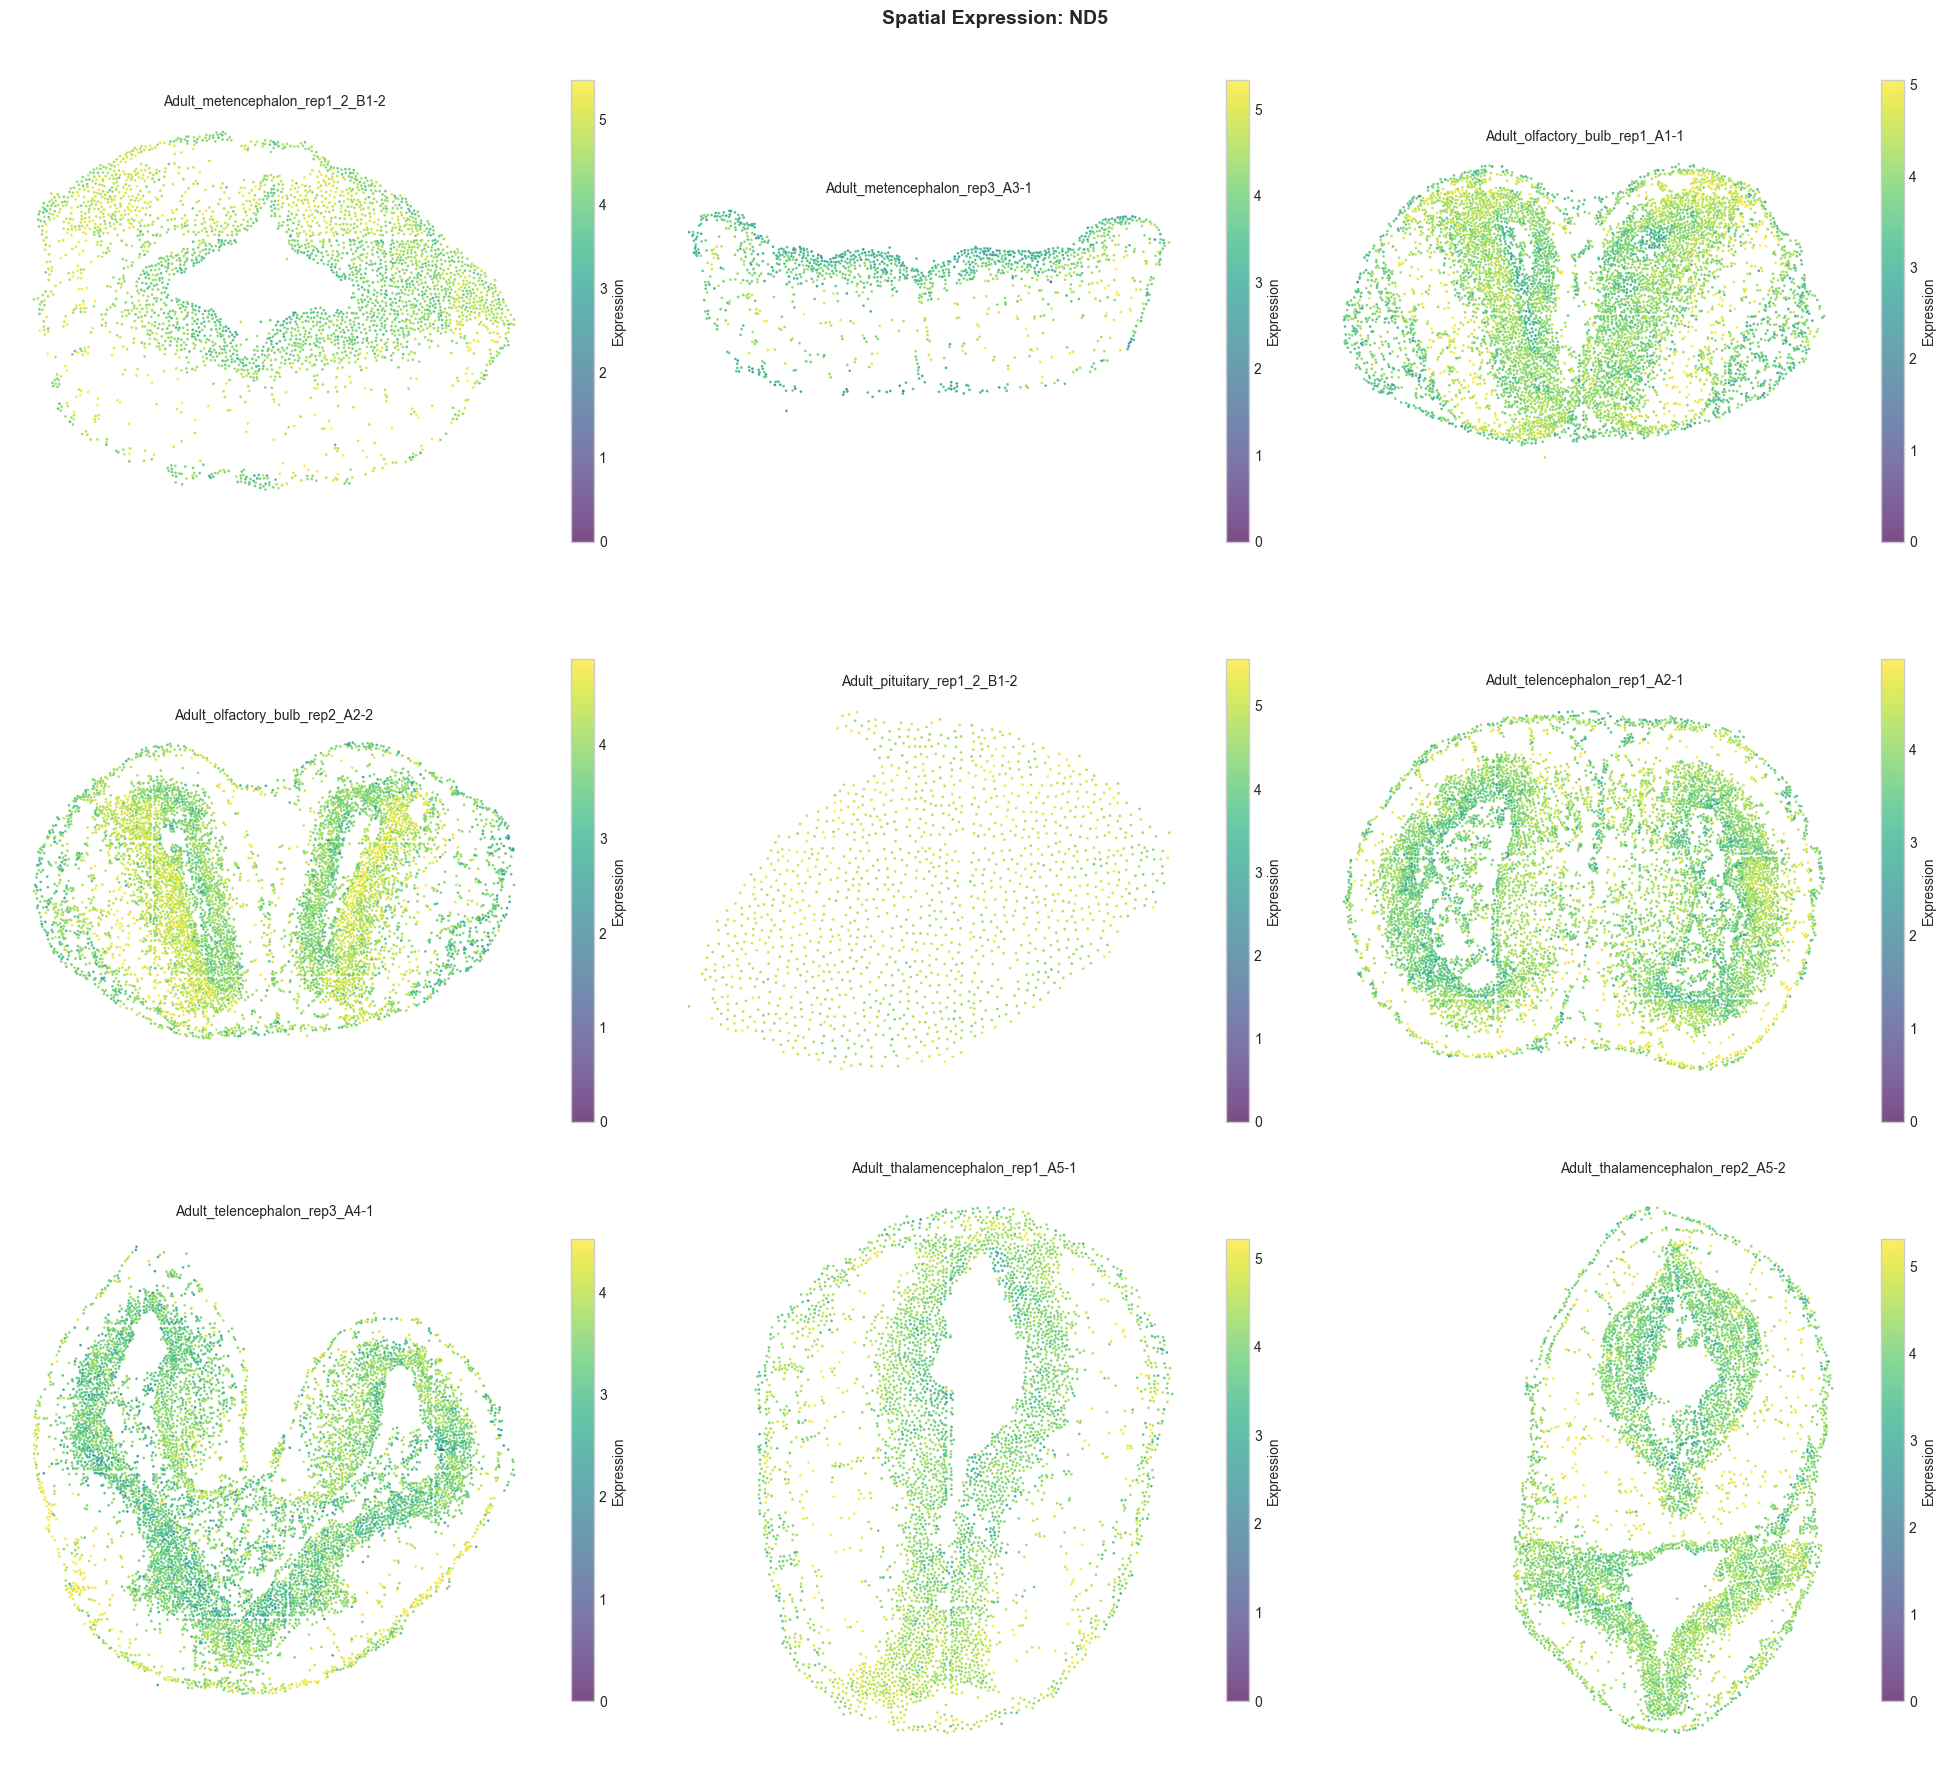


Spatial gene expression plot saved to result/spatial_gene_expression.pdf


In [16]:
fig, axes = plt.subplots(3, 3, figsize=(20, 18))
axes = axes.flatten()

for idx, (name, adata) in enumerate(h5ads.items()):
    if idx >= 9:
        break
    ax = axes[idx]
    
    # Get spatial coordinates
    if 'spatial' in adata.obsm:
        coords = adata.obsm['spatial']
    elif 'X_spatial' in adata.obsm:
        coords = adata.obsm['X_spatial']
    else:
        x_col = [c for c in adata.obs.columns if 'x' in c.lower() and 'umap' not in c.lower()]
        y_col = [c for c in adata.obs.columns if 'y' in c.lower() and 'umap' not in c.lower()]
        if x_col and y_col:
            coords = np.column_stack([adata.obs[x_col[0]].values, adata.obs[y_col[0]].values])
        else:
            continue
    
    # Get gene expression
    if gene_to_plot in adata.var_names:
        gene_idx = adata.var_names.get_loc(gene_to_plot)
        if hasattr(adata.X, 'toarray'):
            expr = adata.X[:, gene_idx].toarray().flatten()
        else:
            expr = adata.X[:, gene_idx].flatten()
        
        scatter = ax.scatter(coords[:, 0], coords[:, 1], 
                            s=1, alpha=0.7, c=expr, cmap='viridis',
                            vmin=0, vmax=np.percentile(expr, 99))
        plt.colorbar(scatter, ax=ax, label='Expression', shrink=0.8)
    else:
        ax.scatter(coords[:, 0], coords[:, 1], s=1, alpha=0.5, c='gray')
        ax.text(0.5, 0.5, 'Gene not found', ha='center', va='center', transform=ax.transAxes)
    
    short_name = name.replace('_region_ann', '').replace('DP8400015649BR_', '').replace('DP8400015234BL_', '')
    ax.set_title(short_name, fontsize=10)
    ax.set_aspect('equal')
    ax.invert_yaxis()
    ax.axis('off')

plt.suptitle(f'Spatial Expression: {gene_to_plot}', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('result/spatial_gene_expression.pdf', dpi=300, bbox_inches='tight')
plt.savefig('result/spatial_gene_expression.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nSpatial gene expression plot saved to result/spatial_gene_expression.pdf")

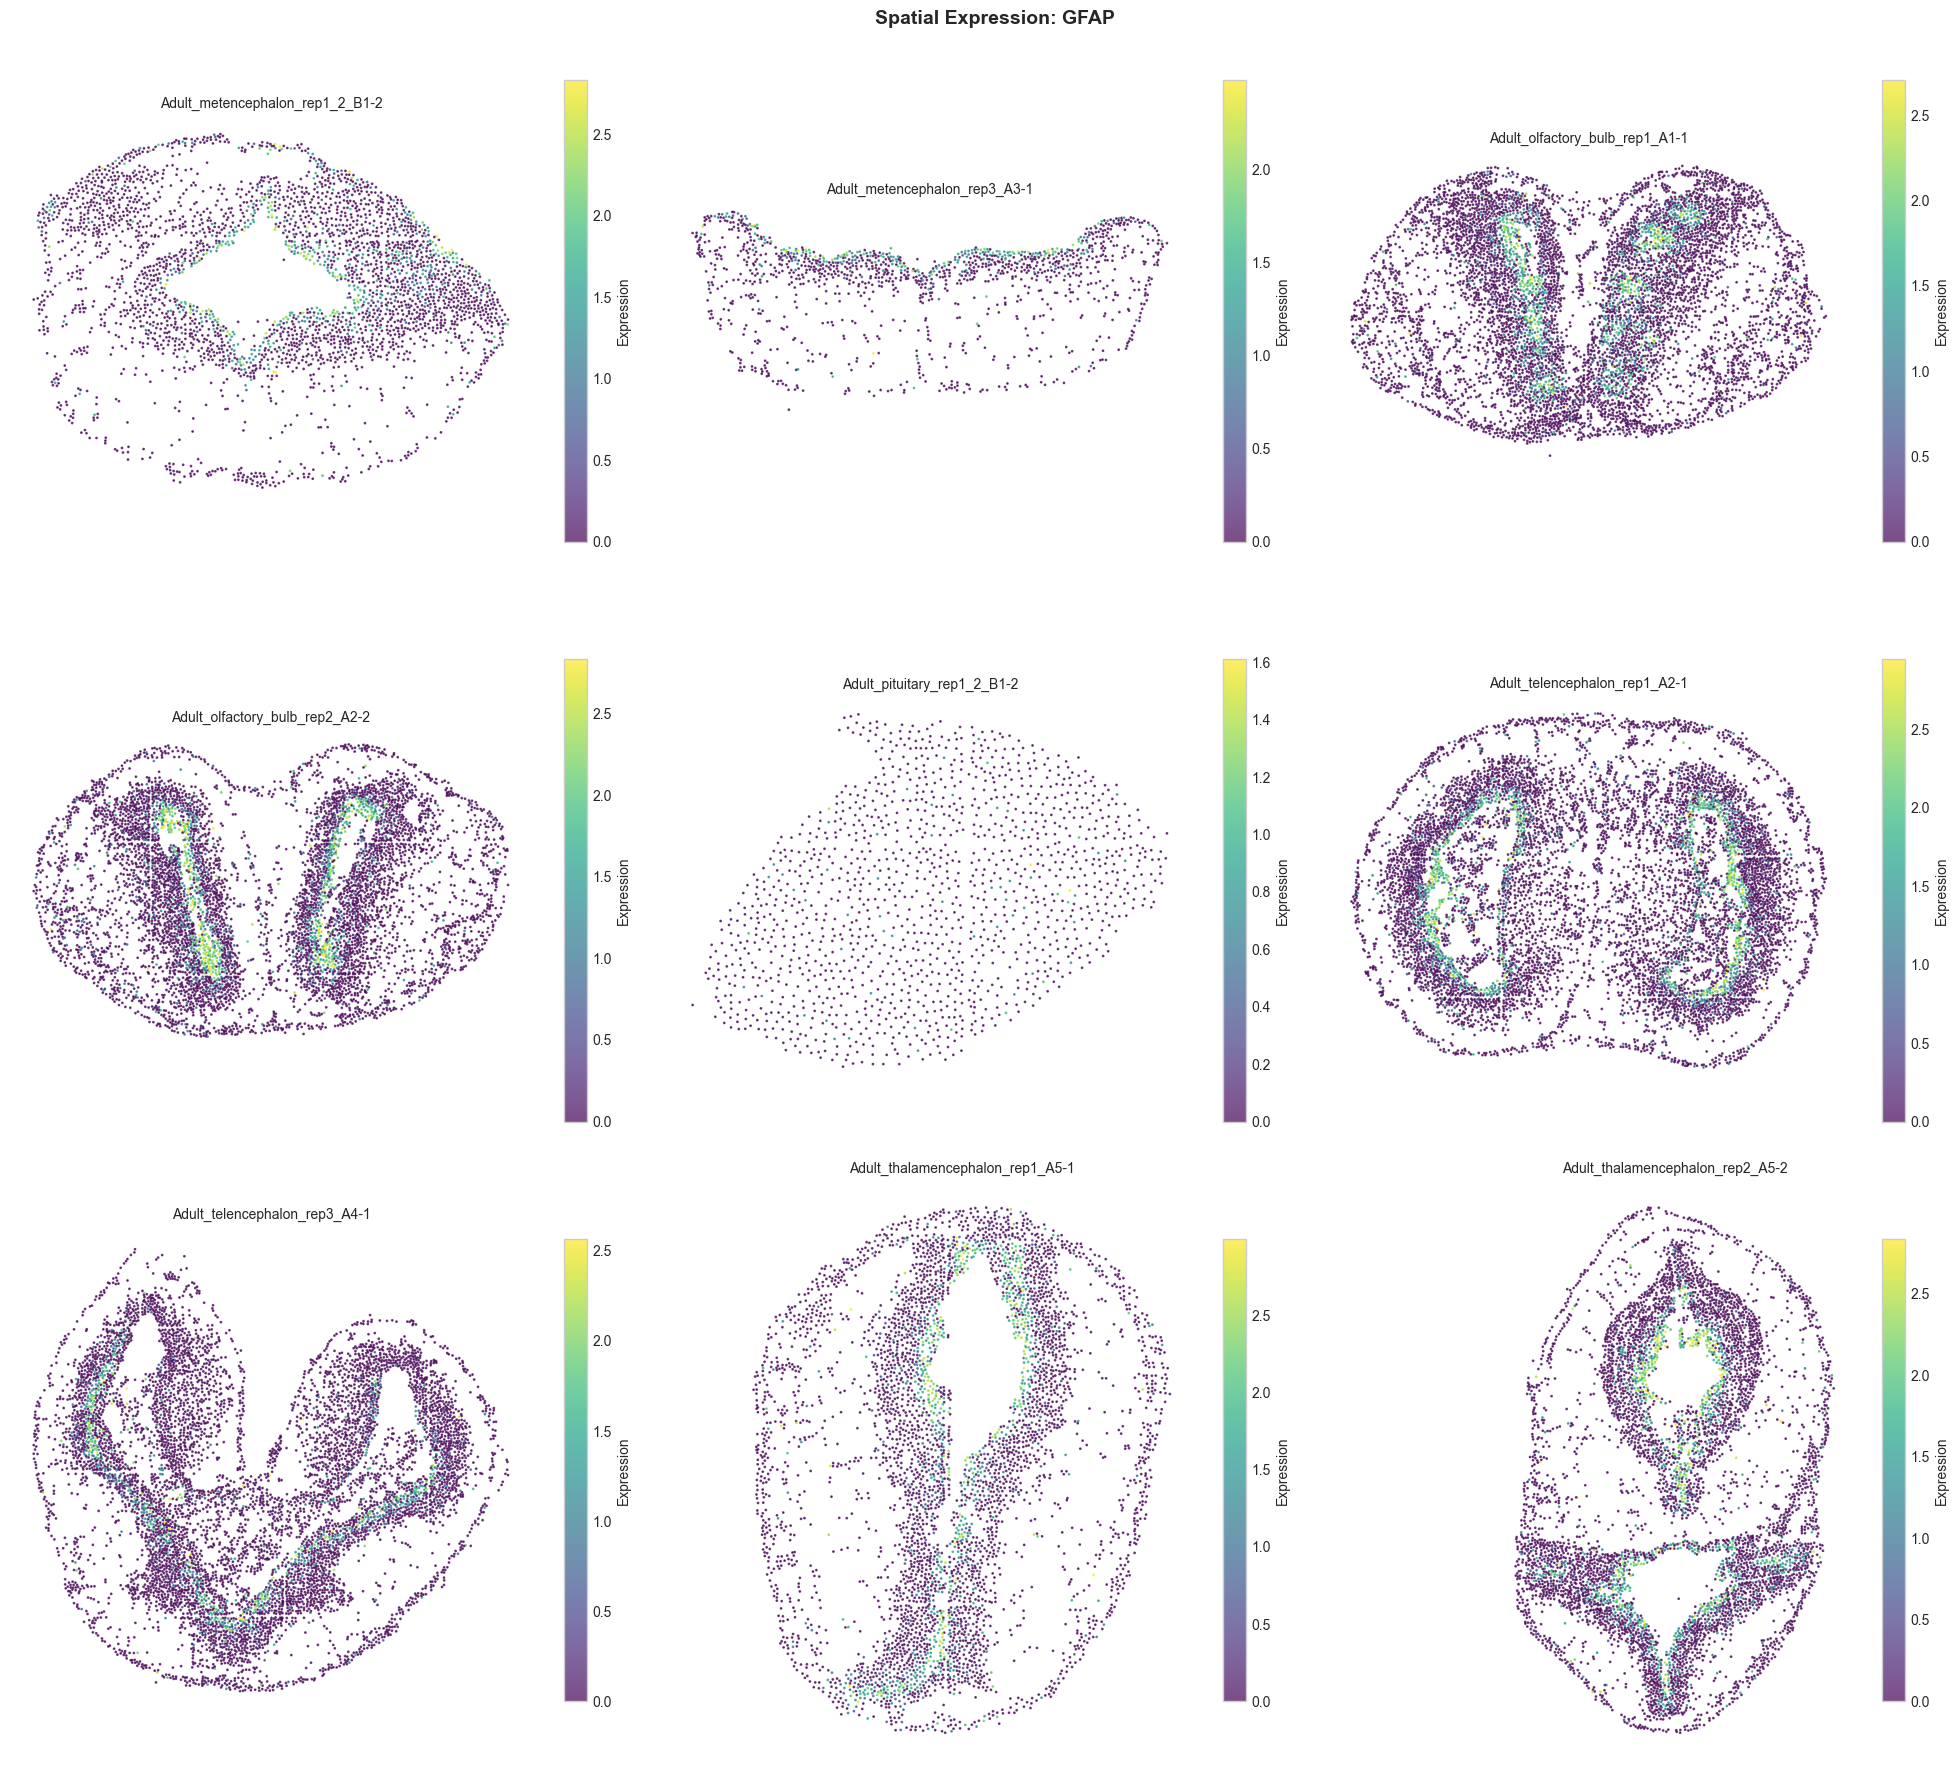


Spatial gene expression plot saved to result/spatial_GFAP_expression.pdf


In [17]:
gene_to_plot = 'GFAP'

fig, axes = plt.subplots(3, 3, figsize=(20, 18))
axes = axes.flatten()

for idx, (name, adata) in enumerate(h5ads.items()):
    if idx >= 9:
        break
    ax = axes[idx]
    
    # Get spatial coordinates
    if 'spatial' in adata.obsm:
        coords = adata.obsm['spatial']
    elif 'X_spatial' in adata.obsm:
        coords = adata.obsm['X_spatial']
    else:
        x_col = [c for c in adata.obs.columns if 'x' in c.lower() and 'umap' not in c.lower()]
        y_col = [c for c in adata.obs.columns if 'y' in c.lower() and 'umap' not in c.lower()]
        if x_col and y_col:
            coords = np.column_stack([adata.obs[x_col[0]].values, adata.obs[y_col[0]].values])
        else:
            continue
    
    # Get gene expression directly - no search
    if gene_to_plot in adata.var_names:
        gene_idx = adata.var_names.get_loc(gene_to_plot)
        if hasattr(adata.X, 'toarray'):
            expr = np.asarray(adata.X[:, gene_idx].toarray()).flatten()
        else:
            expr = np.asarray(adata.X[:, gene_idx]).flatten()
        
        vmax = np.percentile(expr[expr > 0], 99) if (expr > 0).any() else 1
        scatter = ax.scatter(coords[:, 0], coords[:, 1], 
                            s=1, alpha=0.7, c=expr, cmap='viridis',
                            vmin=0, vmax=vmax)
        plt.colorbar(scatter, ax=ax, label='Expression', shrink=0.8)
    else:
        ax.scatter(coords[:, 0], coords[:, 1], s=1, alpha=0.5, c='gray')
        ax.text(0.5, 0.5, 'Gene not found', ha='center', va='center', transform=ax.transAxes)
    
    short_name = name.replace('_region_ann', '').replace('DP8400015649BR_', '').replace('DP8400015234BL_', '')
    ax.set_title(short_name, fontsize=10)
    ax.set_aspect('equal')
    ax.invert_yaxis()
    ax.axis('off')

plt.suptitle(f'Spatial Expression: {gene_to_plot}', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('result/spatial_GFAP_expression.pdf', dpi=300, bbox_inches='tight')
plt.savefig('result/spatial_GFAP_expression.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nSpatial gene expression plot saved to result/spatial_GFAP_expression.pdf")

In [18]:
# G2M phase marker genes - using exact matching only to avoid false positives

g2m_genes_candidates = [
    # Core G2/M markers - using exact names or common patterns
    'MKI67[nr]',      # Ki-67 - peaks at G2/M
    'TOP2A',          # Topoisomerase II alpha
    'CCNB1',          # Cyclin B1
    'CCNB2',          # Cyclin B2
    'CCNA2',          # Cyclin A2
    'CDC20',          # Cell division cycle 20
    'PLK1',           # Polo-like kinase 1
    'AURKA',          # Aurora kinase A (exact)
    'AURKB',          # Aurora kinase B
    'BUB1',           # Mitotic checkpoint
    'BUB1B',          # Mitotic checkpoint
    'CENPA',          # Centromere protein A
    'CENPE',          # Centromere protein E
    'CENPF',          # Centromere protein F
    'CENPN',          # Centromere protein N
    'KIF11',          # Kinesin
    'KIF20A',         # Kinesin
    'KIF23',          # Kinesin
    'NUSAP1',         # Nucleolar spindle
    'TPX2',           # Targeting protein
    'UBE2C',          # Ubiquitin conjugating
    'BIRC5',          # Survivin
    'NUF2',           # Kinetochore
    'PRC1',           # Cytokinesis regulator
    'SMC1A',          # Cohesin (exact)
    'NEK2',           # Centrosome separation
    'DLGAP5',         # G2/M specific
    'H2AZ1',          # Histone variant
    'PTTG1',          # Securin
    'CDK1',           # Master kinase (exact)
    'HMGB2.L[nr]|HMGB2[hs]',          # High mobility group
]

# Check which genes are available - EXACT MATCH ONLY
sample_name = list(h5ads.keys())[0]
adata_test = h5ads[sample_name]

g2m_genes = []
print("Checking for G2M phase markers (EXACT MATCH ONLY)...")
for gene in g2m_genes_candidates:
    if gene in adata_test.var_names:
        g2m_genes.append(gene)
        print(f"  ✓ {gene}")
    else:
        # Try with common suffixes but require gene name at start
        exact_patterns = [
            f"{gene}[",      # e.g., "CDK1[" to avoid CDK17
            f"{gene}.",      # e.g., "CDK1."
            f"{gene}|",      # e.g., "CDK1|"
        ]
        found = False
        for var_name in adata_test.var_names:
            var_str = str(var_name)
            # Check if var_name starts with gene name followed by delimiter
            if var_str == gene or any(var_str.startswith(p) for p in exact_patterns):
                g2m_genes.append(var_name)
                print(f"  ✓ {gene} -> {var_name}")
                found = True
                break
        if not found:
            print(f"  ✗ {gene}")

print(f"\nFound {len(g2m_genes)} G2M genes in data:")
print(f"  {g2m_genes}")


def calculate_g2m_score(adata, gene_list):
    """
    Calculate G2M score as mean z-scored expression of G2M marker genes.
    Similar to Seurat's CellCycleScoring approach.
    """
    from scipy import stats
    
    genes_in_data = [g for g in gene_list if g in adata.var_names]
    
    if len(genes_in_data) == 0:
        adata.obs['g2m_score'] = 0
        return 0
    
    gene_indices = [adata.var_names.get_loc(g) for g in genes_in_data]
    
    if hasattr(adata.X, 'toarray'):
        expr_matrix = adata.X[:, gene_indices].toarray()
    else:
        expr_matrix = adata.X[:, gene_indices]
    
    # Z-score normalize each gene across cells
    z_scores = stats.zscore(expr_matrix, axis=0, nan_policy='omit')
    z_scores = np.nan_to_num(z_scores, 0)
    
    # G2M score is the mean of z-scores across all G2M genes
    adata.obs['g2m_score'] = z_scores.mean(axis=1)
    
    return len(genes_in_data)


# Apply G2M scoring to all samples
print("\nCalculating G2M scores...")
for name, adata in h5ads.items():
    n_genes = calculate_g2m_score(adata, g2m_genes)
    score_range = f"[{adata.obs['g2m_score'].min():.2f}, {adata.obs['g2m_score'].max():.2f}]"
    print(f"  {name}: {n_genes} genes, score range: {score_range}")

print("\nG2M score added to all AnnData objects as 'g2m_score' in obs!")

Checking for G2M phase markers (EXACT MATCH ONLY)...
  ✓ MKI67[nr]
  ✗ TOP2A
  ✗ CCNB1
  ✗ CCNB2
  ✗ CCNA2
  ✗ CDC20
  ✗ PLK1
  ✗ AURKA
  ✗ AURKB
  ✗ BUB1
  ✗ BUB1B
  ✗ CENPA
  ✗ CENPE
  ✗ CENPF
  ✓ CENPN
  ✗ KIF11
  ✗ KIF20A
  ✗ KIF23
  ✗ NUSAP1
  ✗ TPX2
  ✗ UBE2C
  ✗ BIRC5
  ✗ NUF2
  ✗ PRC1
  ✓ SMC1A
  ✗ NEK2
  ✗ DLGAP5
  ✓ H2AZ1
  ✓ PTTG1
  ✗ CDK1
  ✓ HMGB2.L[nr]|HMGB2[hs]

Found 6 G2M genes in data:
  ['MKI67[nr]', 'CENPN', 'SMC1A', 'H2AZ1', 'PTTG1', 'HMGB2.L[nr]|HMGB2[hs]']

Calculating G2M scores...
  Adult_metencephalon_rep1_2_DP8400015234BL_B1-2_region_ann: 6 genes, score range: [-0.37, 2.60]
  Adult_metencephalon_rep3_DP8400015234BL_A3-1_region_ann: 6 genes, score range: [-0.25, 2.90]
  Adult_olfactory_bulb_rep1_DP8400015234BL_A1-1_region_ann: 6 genes, score range: [-0.33, 3.52]
  Adult_olfactory_bulb_rep2_DP8400015234BL_A2-2_region_ann: 6 genes, score range: [-0.38, 3.25]
  Adult_pituitary_rep1_2_DP8400015234BL_B1-2_region_ann: 6 genes, score range: [-0.40, 2.29]
  Adult_tele

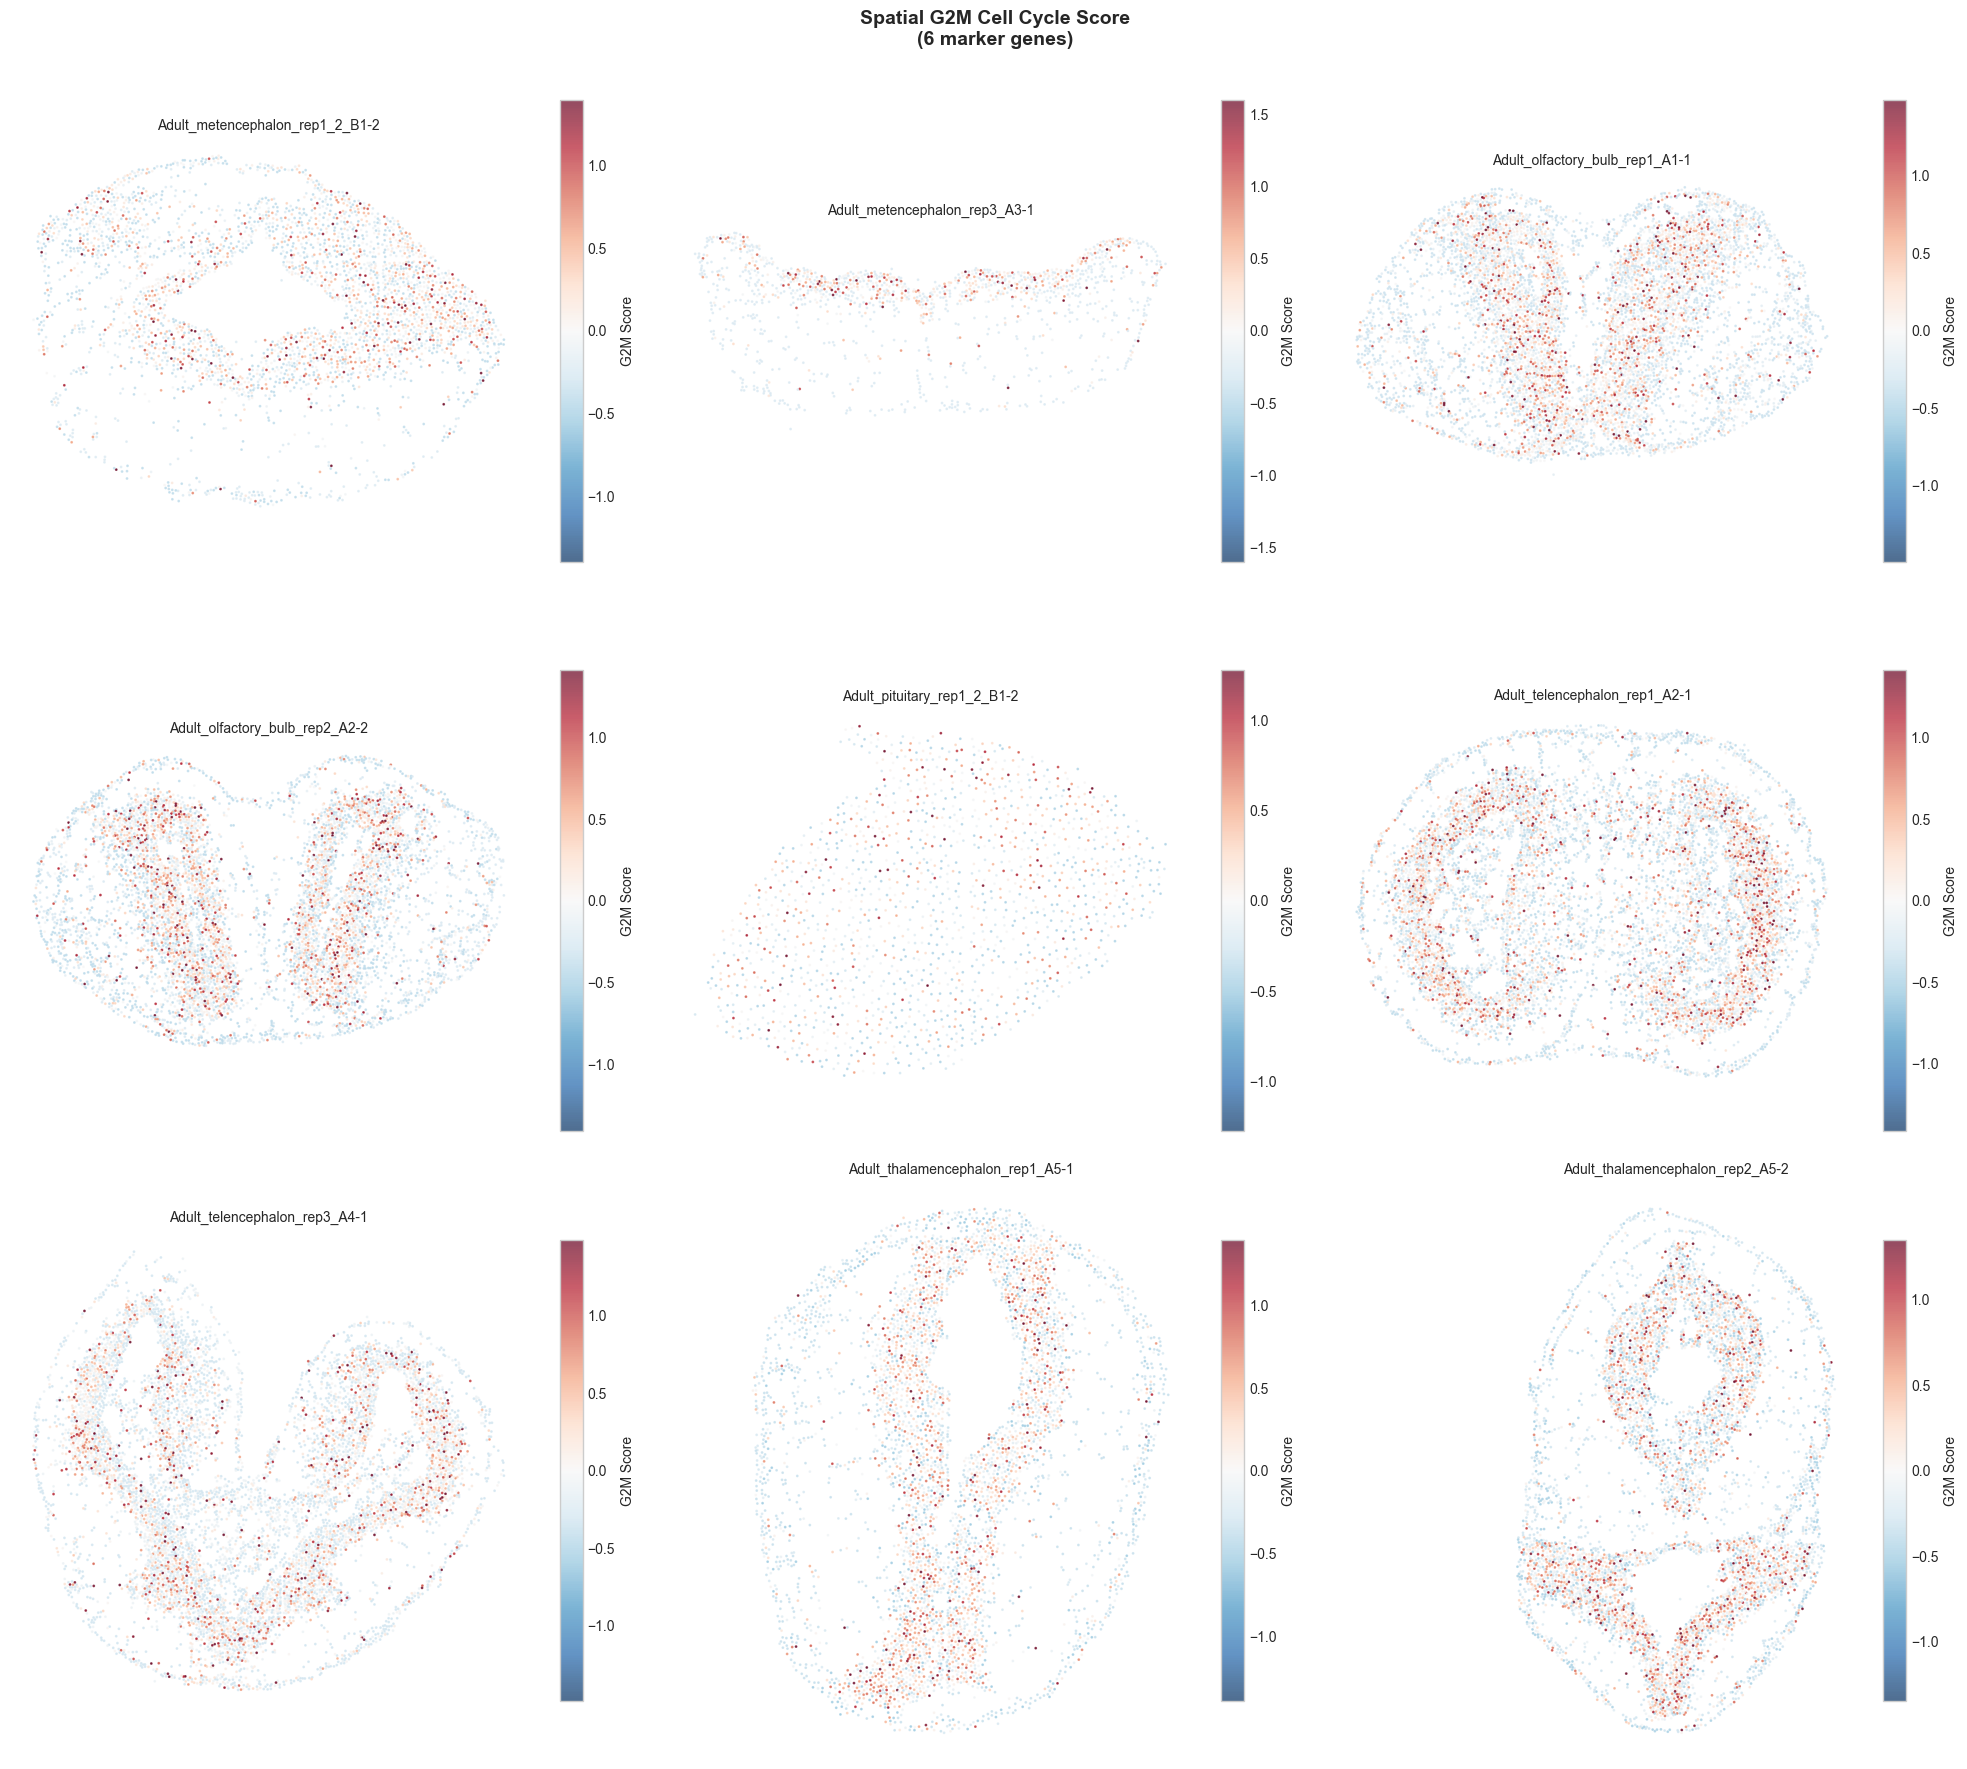


G2M score visualization saved to result/spatial_g2m_score.pdf
Genes used: ['MKI67[nr]', 'CENPN', 'SMC1A', 'H2AZ1', 'PTTG1', 'HMGB2.L[nr]|HMGB2[hs]']


In [19]:
# Visualize G2M score spatially across all samples

fig, axes = plt.subplots(3, 3, figsize=(20, 18))
axes = axes.flatten()

for idx, (name, adata) in enumerate(h5ads.items()):
    if idx >= 9:
        break
    ax = axes[idx]
    
    # Get spatial coordinates
    if 'spatial' in adata.obsm:
        coords = adata.obsm['spatial']
    elif 'X_spatial' in adata.obsm:
        coords = adata.obsm['X_spatial']
    else:
        x_col = [c for c in adata.obs.columns if 'x' in c.lower() and 'umap' not in c.lower()]
        y_col = [c for c in adata.obs.columns if 'y' in c.lower() and 'umap' not in c.lower()]
        if x_col and y_col:
            coords = np.column_stack([adata.obs[x_col[0]].values, adata.obs[y_col[0]].values])
        else:
            ax.text(0.5, 0.5, 'No spatial coords', ha='center', va='center', transform=ax.transAxes)
            continue
    
    # Get G2M score
    if 'g2m_score' in adata.obs.columns:
        score = adata.obs['g2m_score'].values
        
        # Use diverging colormap centered at 0
        vmax = np.percentile(np.abs(score), 99)
        scatter = ax.scatter(coords[:, 0], coords[:, 1], 
                            s=1, alpha=0.7, c=score, cmap='RdBu_r',
                            vmin=-vmax, vmax=vmax)
        plt.colorbar(scatter, ax=ax, label='G2M Score', shrink=0.8)
    else:
        ax.scatter(coords[:, 0], coords[:, 1], s=1, alpha=0.5, c='gray')
        ax.text(0.5, 0.5, 'No G2M score', ha='center', va='center', transform=ax.transAxes)
    
    short_name = name.replace('_region_ann', '').replace('DP8400015649BR_', '').replace('DP8400015234BL_', '')
    ax.set_title(short_name, fontsize=10)
    ax.set_aspect('equal')
    ax.invert_yaxis()
    ax.axis('off')

plt.suptitle(f'Spatial G2M Cell Cycle Score\n({len(g2m_genes)} marker genes)', 
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('result/spatial_g2m_score.pdf', dpi=300, bbox_inches='tight')
plt.savefig('result/spatial_g2m_score.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nG2M score visualization saved to result/spatial_g2m_score.pdf")
print(f"Genes used: {g2m_genes}")

/var/folders/62/0nz2_4cx7m5fddwztmh0lflc0000gp/T/ipykernel_4224/1146034232.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=g2m_df, x='brain_region', y='g2m_score', ax=ax1, palette='Set2', cut=0)
/var/folders/62/0nz2_4cx7m5fddwztmh0lflc0000gp/T/ipykernel_4224/1146034232.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')


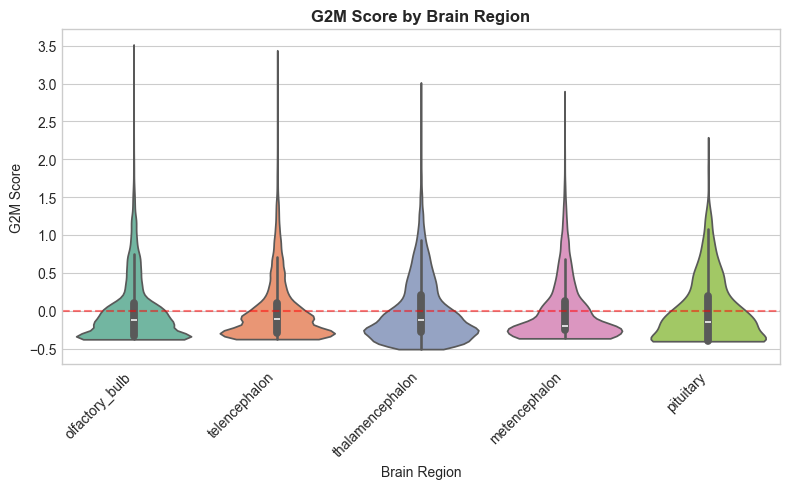


G2M Score Summary by Brain Region:
                  mean  median    std  count
brain_region                                
olfactory_bulb    -0.0  -0.123  0.421  12920
telencephalon     -0.0  -0.116  0.419  15553
thalamencephalon  -0.0  -0.127  0.432  15604
metencephalon     -0.0  -0.202  0.424   4484
pituitary         -0.0  -0.147  0.424   1364


/var/folders/62/0nz2_4cx7m5fddwztmh0lflc0000gp/T/ipykernel_4224/1146034232.py:43: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(g2m_df.groupby('brain_region')['g2m_score'].agg(['mean', 'median', 'std', 'count']).round(3))


In [20]:
# G2M score distribution by brain region

# Collect G2M scores with metadata
g2m_data = []
for name, adata in h5ads.items():
    if 'g2m_score' in adata.obs.columns:
        parts = name.split('_')
        brain_region = parts[1]
        if 'olfactory' in name:
            brain_region = 'olfactory_bulb'
        
        df_temp = pd.DataFrame({
            'g2m_score': adata.obs['g2m_score'].values,
            'sample': name,
            'brain_region': brain_region
        })
        g2m_data.append(df_temp)

g2m_df = pd.concat(g2m_data, ignore_index=True)

# Set brain region order
brain_levels = ['olfactory_bulb', 'telencephalon', 'thalamencephalon', 'metencephalon', 'pituitary']
g2m_df['brain_region'] = pd.Categorical(g2m_df['brain_region'], categories=brain_levels, ordered=True)

# Plot
fig, ax1 = plt.subplots(1, 1, figsize=(8, 5))

# Violin plot by brain region
sns.violinplot(data=g2m_df, x='brain_region', y='g2m_score', ax=ax1, palette='Set2', cut=0)
ax1.axhline(y=0, color='red', linestyle='--', alpha=0.5)
ax1.set_title('G2M Score by Brain Region', fontsize=12, fontweight='bold')
ax1.set_xlabel('Brain Region')
ax1.set_ylabel('G2M Score')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.savefig('result/g2m_score_distribution.pdf', dpi=300, bbox_inches='tight')
plt.savefig('result/g2m_score_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

# Summary statistics
print("\nG2M Score Summary by Brain Region:")
print(g2m_df.groupby('brain_region')['g2m_score'].agg(['mean', 'median', 'std', 'count']).round(3))

In [21]:
from pathlib import Path
import pandas as pd

# Save all rotated and gene-renamed AnnData objects with _final postfix

output_dir = Path("data")
output_dir.mkdir(parents=True, exist_ok=True)

saved = []
errors = []

for name, adata in h5ads.items():
    # Ensure var names are strings and unique (the objects should already be renamed earlier)
    try:
        adata.var_names = pd.Index([str(v) for v in adata.var_names])
        adata.var_names_make_unique()
    except Exception:
        # If var_names cannot be coerced, continue but note it
        print(f"Warning: could not enforce var_names as strings for {name}")

    # Create output filename: remove _region_ann if present and add _final.h5ad
    base_name = name.replace('_region_ann', '')
    output_filename = f"{base_name}_final.h5ad"
    output_path = output_dir / output_filename

    # Save the (rotated + gene-renamed) AnnData object
    try:
        # Use str(path) for compatibility with different anndata versions
        adata.write_h5ad(str(output_path))
        saved.append(str(output_path))
        print(f"Saved {output_filename}")
    except Exception as e:
        errors.append((name, str(e)))
        print(f"Failed to save {output_filename}: {e}")

print(f"\nAll processed. Intended: {len(h5ads)} files. Successfully saved: {len(saved)}")
if errors:
    print(f"Errors: {len(errors)}")
    for n, msg in errors:
        print(f"  - {n}: {msg}")
else:
    print(f"All files saved to: {output_dir.resolve()}")

Saved Adult_metencephalon_rep1_2_DP8400015234BL_B1-2_final.h5ad
Saved Adult_metencephalon_rep3_DP8400015234BL_A3-1_final.h5ad
Saved Adult_olfactory_bulb_rep1_DP8400015234BL_A1-1_final.h5ad
Saved Adult_olfactory_bulb_rep2_DP8400015234BL_A2-2_final.h5ad
Saved Adult_pituitary_rep1_2_DP8400015234BL_B1-2_final.h5ad
Saved Adult_telencephalon_rep1_DP8400015234BL_A2-1_final.h5ad
Saved Adult_telencephalon_rep3_DP8400015234BL_A4-1_final.h5ad
Saved Adult_thalamencephalon_rep1_DP8400015234BL_A5-1_final.h5ad
Saved Adult_thalamencephalon_rep2_DP8400015234BL_A5-2_final.h5ad
Saved Adult_thalamencephalon_rep3_DP8400015234BL_A6-1_final.h5ad

All processed. Intended: 10 files. Successfully saved: 10
All files saved to: /Users/sebastian.boehm/Documents/A_Feng_spatial/Fengalotl/data
